# Library

In [2]:
import logging
import requests
from bs4 import BeautifulSoup
from urllib.error import HTTPError

import http.client as httplib  # or http.client if you're on Python 3 # httplib
httplib._MAXHEADERS = 10000
# ChunkedEncodingError

import time
import datetime
from datetime import datetime, timedelta

import re

import json

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import sys

import random 
from random import sample

In [3]:
# pathes
art_project_path = '/content/drive/MyDrive/Art/Art_Project'
art_project_path_backups = '/content/drive/MyDrive/Art/Art_Project/parsing_backups'
art_project_path_tests = '/content/drive/MyDrive/Art/Art_Project/parsing_tests'

url_add = 'https://www.artsy.net'

# files
cat_dict = '/artsy_genom_cat_dict.txt'
gen_dict = '/artsy_genom_gen_dict.txt'
artwork_dict = '/artsy_genom_artwork_dict.txt'
artist_dict = '/artsy_genom_artist_dict.txt'
temp_data = '/artsy_temp_data.csv'
temp_data_add_up = '/artsy_temp_data_add_up.csv'

# id length
cat_id_len = 2
gen_id_len = 5
artist_id_len = 5

# for addition and updating
recently_added_pref = '?sort=-published_at'
recently_updated_pref = '?sort=-partner_updated_at'

# Functions

## Openings and savings

In [4]:
# 1. Save json dict
def save_dict(tree_dict, file, folder):
  if folder=='live':
    with open(art_project_path + file, 'w') as outfile:
      json.dump(tree_dict, outfile)
  elif folder=='backup':
    with open(art_project_path_backups + file, 'w') as outfile:
      json.dump(tree_dict, outfile)

# 2. Open json dict
def open_dict(file, folder):
  if folder=='live':
    with open(art_project_path + file, 'rb') as infile:
      tree_dict = json.load(infile)
  elif folder=='backup':
    with open(art_project_path_backups + file, 'rb') as infile:
      tree_dict = json.load(infile)
  return tree_dict

# 3. Open file.csv
def open_file_csv(file, folder): # folder: live, backup or test
  if folder=='live':
    df = pd.read_csv(art_project_path + file)
  elif folder=='backup':
    df = pd.read_csv(art_project_path_backups + file)
  elif folder=='test':
    df = pd.read_csv(art_project_path_tests + file)
  return df

# 4. Save df to csv file
def save_df_file(df, file, folder): # folder: live, backup or test
  if folder=='live':
    df.to_csv(art_project_path + file, index=False)
  elif folder=='backup':
    df.to_csv(art_project_path_backups + file, index=False)
  elif folder=='test':
    df.to_csv(art_project_path_tests + file, index=False)


## Parsing

### get_page

In [5]:
# 5. get_page
logging.basicConfig(level=logging.DEBUG, format="%(message)s")

def get_page(url, session):
  #response = requests.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})
  try:
    response = session.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})
  except: # requests.exceptions.ChunkedEncodingError:
    time.sleep(0.5)
    session = requests.Session()
    response = session.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})

  try:
    response.raise_for_status()
  except requests.exceptions.HTTPError: # for correction
    sys.exit(print('HTTPError: ' + str(url)))

  bs_page = BeautifulSoup(response.text, 'html.parser')
  return bs_page

### get next pages links list

In [6]:
# 6. get next pages links list
def get_next_page_list(url, page):
  try:
    last_page_data = page.find('main').find_all('nav', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 ibHUpM gzwvJD')[0].find_all('a')[-2]
    last_page = last_page_data.get_text()
    page_link = last_page_data.get('href')[:-len(last_page)]
    next_page_link_list_new = [url + page_link + str(p) for p in range(2, int(last_page)+1)]
  except:
    next_page_link_list_new = []

  return next_page_link_list_new

# 6.1 get next pages links list
def get_next_page_list_add_up(url, page):
  try:
    last_page_data = page.find('main').find_all('nav', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 ibHUpM gzwvJD')[0].find_all('a')[-2]
    last_page = last_page_data.get_text()
    last_page_link = last_page_data.get('href')
    next_page_link_list_new = [url + last_page_link.split('&')[0][:-len(last_page)] + str(p) + '&' + last_page_link.split('&')[1] for p in range(2, int(last_page)+1)]
  except:
    next_page_link_list_new = []

  return next_page_link_list_new

In [7]:
# https://www.artsy.net/gene/inlay
# https://www.artsy.net/gene/inlay?page=2
# https://www.artsy.net/gene/inlay?sort=-published_at
# https://www.artsy.net/gene/inlay?page=2&sort=-published_at

### get data from pages

In [8]:
# 7. get data from pages
def get_page_data(page):
  code_block = page.find('main').find_all('div', class_='ArtworkGrid-sc-1jsqquq-0 djwrUe')
  try:
    object_block = code_block[0].find_all('div', relay='[object Object]')
  
    # for the beggining into a DataFrame
    artsy_id_list = [obj.get('data-id') for obj in object_block]
    imgage_list = [obj.find_all('a')[0].find('img').get('src') for obj in object_block]
    artist_list = [obj.find_all('a')[1].find_all('div')[0].get_text() for obj in object_block]
  
    gallery_list = []
    for obj in object_block:
      try:
        gallery_list.append(obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 caIGcn hENCPo').get_text())
      except:
        gallery_list.append(np.nan)
  
    price_list = []
    for obj in object_block:
      try:
        price_list.append(obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 eXbAnU jkuGdd').get_text())
      except:
        price_list.append(np.nan)
  
    # can be no year info !!!
    name_list = []
    year_list = []
    for obj in object_block:
      text = obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 caIGcn kySEpG').get_text()
      name = obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 caIGcn kySEpG').find('i').get_text()
      year = text.replace(name, '').replace(', ', '')
      if len(year)==0:
        year = np.nan
      name_list.append(name)
      year_list.append(year)

    df_data_new = pd.DataFrame({'artsy_id': artsy_id_list,
                                'name': name_list, 
                                'link': imgage_list, 
                                'year': year_list,
                                'artist': artist_list,
                                'gallery': gallery_list,
                                'price': price_list
                                })
  except:
    df_data_new = pd.DataFrame({'artsy_id': np.nan,
                                'name': np.nan, 
                                'link': np.nan, 
                                'year': np.nan,
                                'artist': np.nan,
                                'gallery': np.nan,
                                'price': np.nan
                                }, index=[0])
  
  return df_data_new

### get category data into df - aggregator

In [9]:
# Function aggregator
# 8. Get the all category data into DataFrame
def get_df_data(df_input, genes_links_list, genes_ids_list, cat):
  start_time = time.time()
  print(datetime.now().time())
  df_output = df_input.copy()
  df_output = df_output[0:0]

  for link in genes_links_list:
    session = requests.Session()
    total_link = url_add + link
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has started')
    # 5. get_page
    gene_page = get_page(total_link, session)
    #           get_page(url, session) -> 
    # -> bs_page
    
    # 6. get next pages links list
    next_page_link_list = get_next_page_list(url_add, gene_page)
    #                     get_next_page_list(url, page) -> 
    # -> next_page_link_list_new
    print(len(next_page_link_list)+1, 'pages for parsing')

    # 7. get data from pages
    df_data = get_page_data(gene_page)
    #         get_page_data(page) -> 
    # -> df_data_new
    df_data['gene_id'] = genes_ids_list[genes_links_list.index(link)]
    df_data['category_id'] = cat
    df_data['parsing_date'] = datetime.now().date().strftime('%Y-%m-%d')
    df_data['updating_date'] = datetime.now().date().strftime('%Y-%m-%d')

    df_output = pd.concat([df_output, df_data])

    # Get data from next pages
    if len(next_page_link_list) > 0:
      for page_link in next_page_link_list:
        # 5. get_page
        gene_page = get_page(page_link, session)
        #           get_page(url, session) -> 
        # -> bs_page

        # 7. get data from pages
        df_data = get_page_data(gene_page)
        #         get_page_data(page) -> 
        # -> df_data_new
        df_data['gene_id'] = genes_ids_list[genes_links_list.index(link)]
        df_data['category_id'] = cat
        df_data['parsing_date'] = datetime.now().date().strftime('%Y-%m-%d')
        df_data['updating_date'] = datetime.now().date().strftime('%Y-%m-%d')

        df_output = pd.concat([df_output, df_data])
      
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has finished')
    print((time.time() - start_time), 'seconds have passed')
    print(datetime.now().time())
    print('')
    time.sleep(0.5)

  return df_output

In [10]:
# Function aggregator
# 8.1 Get the first pages category data into DataFrame
def get_df_data_add_up(df_input, genes_links_list, genes_ids_list, genes_cat_list): # cat !!!!!!!!
  start_time = time.time()
  print(datetime.now().time())
  df_output = df_input.copy()
  #df_output['pages_count'] = np.nan # only for the first time !!!!
  #df_output['second_page_link'] = np.nan # only for the first time !!!!
  df_output = df_output[0:0]

  session = requests.Session()
  l_c = 0
  for link in genes_links_list:
    #session = requests.Session()
    total_link = url_add + link
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has started')
    # 5. get_page
    gene_page = get_page(total_link, session)
    #           get_page(url, session) -> 
    # -> bs_page
    
    # 6.1 get next pages links list
    next_page_link_list = get_next_page_list_add_up(url_add, gene_page)
    #                     get_next_page_list_add_up(url, page) -> 
    # -> next_page_link_list_new
    print(len(next_page_link_list)+1, 'pages for parsing')

    # 7. get data from pages
    df_data = get_page_data(gene_page)
    #         get_page_data(page) -> 
    # -> df_data_new
    df_data['gene_id'] = genes_ids_list[genes_links_list.index(link)]
    df_data['category_id'] = genes_cat_list[genes_links_list.index(link)] # cat !!!!!!!!!
    df_data['parsing_date'] = datetime.now().date().strftime('%Y-%m-%d')
    df_data['updating_date'] = datetime.now().date().strftime('%Y-%m-%d')
    df_data['pages_count'] = len(next_page_link_list)+1
    if len(next_page_link_list) > 0:
      df_data['second_page_link'] = next_page_link_list[0]
    else:
      df_data['second_page_link'] = np.nan

    df_output = pd.concat([df_output, df_data])
      
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has finished')
    print((time.time() - start_time), 'seconds have passed')
    print(datetime.now().time())
    print('')
    time.sleep(0.5)
    l_c += 1
    if l_c == 10:
      session = requests.Session()
      l_c = 0

  return df_output

### correct image link

In [11]:
# 9. correct image link
def img_link_corr(img):
  parts = img.split('.jpg')[0].replace('?', '/').replace('%2F', '/').split('/')
  img_new = parts[0] + '//' + parts[5] + '/' + parts[6] + '/' + parts[7]  + '.jpg'
  return img_new

### filtering

In [12]:
# 10. Filtering
def get_cat_id(cat):
  return cat

def gene_links_samples(gen_key):
  cat_id = get_cat_id(cat)
  return genes_dict[gen_key]['category_id'] == cat_id

# Gens dict

In [161]:
url = 'https://www.artsy.net/categories'

In [162]:
response = requests.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})
genome_page = BeautifulSoup(response.text, 'html.parser')
genome_page.title.string

Starting new HTTPS connection (1): www.artsy.net:443
https://www.artsy.net:443 "GET /categories HTTP/1.1" 200 None


'Artsy — Discover, Buy, and Sell Fine Art'

## categories_dict

In [ ]:
# !!!!! For the first time !!!!!
confirmation = input('Confirm the categories_dict re/seting (y/n)')
if confirmation == 'y':
  categories_dict = {}
  print('categories_dict has been re/set {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict re/seting (y/n)y
categories_dict has been re/set 2022-03-30 06:01
dictionary's length is - 0


In [163]:
# !!!!! All next times !!!!!
confirmation = input('Confirm the categories_dict opening (y/n)')
if confirmation == 'y':
  categories_dict = open_dict(cat_dict, 'live') # 2. Open json dict
  print('categories_dict has been opened {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict opening (y/n)y
categories_dict has been opened 2022-04-20 07:10
dictionary's length is - 16


In [164]:
categories_dict['artistic_disciplines']

{'genes_id': ['01001', '01002', '01003', '01004', '01005', '01006', '01007'],
 'id': '01',
 'link': 'jump--artistic-disciplines',
 'name': 'Artistic Disciplines',
 'parsing_date': '2022-03-30',
 'updating_date': '2022-03-30'}

In [165]:
categories_block = genome_page.find('div', class_='sticky-inner-wrapper').find_all('div', class_='Box-sc-15se88d-0 Flex-cw39ct-0 elJsUD')

#categories_dict = {'artistic_disciplines': {'id': '02', 'name': 'Artistic Disciplines', 'link': 'jump--artistic-disciplines'}}
id = len(categories_dict) + 1
for cat in categories_block:
  key = cat.find('a').get('href').replace('#jump--', '').replace('-', '_')
  if key not in categories_dict.keys():
    categories_dict.update({key: {'id': str(id) if len(str(id))>1 else '0'+str(id), 'name': cat.get_text(), 'link': cat.find('a').get('href').replace('#', ''), 'genes_id': [], 'parsing_date': datetime.now().date().strftime('%Y-%m-%d'), 'updating_date': datetime.now().date().strftime('%Y-%m-%d')}})
    id += 1
    print('New key has been added - {}'.format(key))
  else:
    if categories_dict[key]['link'] != cat.find('a').get('href').replace('#', '') or categories_dict[key]['name'] != cat.get_text():
      print('an Old name - {}\nor an Old link - {}'.format(categories_dict[key]['name'], categories_dict[key]['link']))
      categories_dict[key].update({'link': cat.find('a').get('href').replace('#', '')})
      categories_dict[key].update({'name': cat.get_text()})
      categories_dict[key].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})
      print('has been updated with \na New name - {}\nor a New link - {}'.format(categories_dict[key]['name'], categories_dict[key]['link']))
      print('')

In [166]:
len(categories_dict)

16

In [167]:
categories_dict['artistic_disciplines']

{'genes_id': ['01001', '01002', '01003', '01004', '01005', '01006', '01007'],
 'id': '01',
 'link': 'jump--artistic-disciplines',
 'name': 'Artistic Disciplines',
 'parsing_date': '2022-03-30',
 'updating_date': '2022-03-30'}

In [ ]:
confirmation = input('Confirm the categories_dict saving (y/n)')
if confirmation == 'y':
  save_dict(categories_dict, cat_dict) # 1. Save json dict
  print('categories_dict has been saved {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict saving (y/n)y
categories_dict has been saved 2022-03-30 06:02
dictionary's length is - 16


## genes_dict

In [ ]:
# !!!!! For the first time !!!!!
confirmation = input('Confirm the genes_dict re/seting (y/n)')
if confirmation == 'y':
  genes_dict = {}
  print('genes_dict has been re/set {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(genes_dict)))
else:
  print('nothing has happened')

Confirm the genes_dict re/seting (y/n)y
genes_dict was re/set


In [168]:
# !!!!! All next times !!!!!
confirmation = input('Confirm the genes_dict opening (y/n)')
if confirmation == 'y':
  genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
  print('genes_dict has been opened {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(genes_dict)))
else:
  print('nothing has happened')

Confirm the genes_dict opening (y/n)y
genes_dict has been opened 2022-04-20 07:14
dictionary's length is - 1032


In [171]:
# !!!!! All next times !!!!!
# Determining the count of genes in the category for creating an id (using () instead of [] is also possible)
count_list = [sum([1 for v in genes_dict.values() if v['category_id']==value['id']]) for value in categories_dict.values()]
id_len = len(str(max(count_list)))
print(id_len)
print(count_list)

3
[7, 213, 252, 26, 75, 175, 20, 68, 39, 22, 69, 27, 6, 7, 19, 7]


In [170]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [172]:
#genes_dict = {'architecture_1': {'id': '0201', 'name': 'Architecture', 'link': '/gene/architecture-1', 'category_id': '02'}}
# !!! working link is 'https://www.artsy.net' + link !!!
for value in categories_dict.values():
  category = genome_page.find('div', id=value['link']).find('h2').text
  if category == value['name']:
    count = sum([1 for v in genes_dict.values() if v['category_id'] == value['id']])
    id = count+1
    gens_block = genome_page.find('div', id=value['link']).find_all('a')
    for a in gens_block:
      gen_key = a.get('href').replace('/gene/', '').replace('-', '_')
      if gen_key not in genes_dict.keys():
        genes_dict.update({gen_key: {'id': value['id']+('0'*(id_len-len(str(id)))+str(id)), 'name': a.get_text(), 'link': a.get('href'), 'category_id': value['id'], 'artsy_id': [], 'artist_id': [], 'parsing_date': datetime.now().date().strftime('%Y-%m-%d'), 'updating_date': datetime.now().date().strftime('%Y-%m-%d')}})
        id += 1
        print('New key has been added - {}'.format(gen_key)) # !!! Not for the first time
      else:
        if genes_dict[gen_key]['link'] != a.get('href') or genes_dict[gen_key]['name'] != a.get_text():
          print('an Old name - {}\nor an Old link - {}'.format(genes_dict[gen_key]['name'], genes_dict[gen_key]['link']))
          genes_dict[gen_key].update({'link': a.get('href')})
          genes_dict[gen_key].update({'name': a.get_text()})
          genes_dict[gen_key].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})
          print('has been updated with \na New name - {}\nor a New link - {}'.format(genes_dict[gen_key]['name'], genes_dict[gen_key]['link']))
          print('')
  else:
    print("Category name doesn't match")

New key has been added - nft


In [173]:
len(genes_dict)

1033

In [174]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [182]:
filtered_dict = {k: v for k, v in categories_dict.items() if v['id'] == genes_dict['nft']['category_id']}
print('New gene in category:', list(filtered_dict.keys())[0])
print('')
genes_dict['nft']

New gene in category: medium_and_techniques



{'artist_id': [],
 'artsy_id': [],
 'category_id': '06',
 'id': '06176',
 'link': '/gene/nft',
 'name': 'NFT',
 'parsing_date': '2022-04-20',
 'updating_date': '2022-04-20'}

In [185]:
print(url_add + genes_dict['nft']['link'])

https://www.artsy.net/gene/nft


In [177]:
confirmation = input('Confirm the genes_dict saving (y/n)')
if confirmation == 'y':
  save_dict(genes_dict, gen_dict, 'live') # 1. Save json dict
  print('genes_dict was saved {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(genes_dict)))
else:
  print('nothing has happened')

Confirm the genes_dict saving (y/n)y
genes_dict was saved 2022-04-20 07:24
dictionary's length is - 1033


### addition/updating lists of genes' id into the categories_dict

In [ ]:
# Dict of genes' id for the categories_dict
#cat_gen_id_dict = {}
#for value in categories_dict.values():
#  gen_id_list = [v['id'] for v in genes_dict.values() if v['category_id'] == value['id']]
#  cat_gen_id_dict.update({value['id']: gen_id_list})

#len(cat_gen_id_dict)

16

In [ ]:
#cat_gen_id_dict['01']

['01001', '01002', '01003', '01004', '01005', '01006', '01007']

In [ ]:
#for k, v in categories_dict.items():
#  for key, value in cat_gen_id_dict.items():
#    if v['id'] == key and categories_dict[k]['genes_id'] != value:
#      categories_dict[k].update({'genes_id': value})
#      categories_dict[k].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})

#len(categories_dict)

16

In [186]:
for key, value in categories_dict.items():
  gen_id_list = [v['id'] for v in genes_dict.values() if v['category_id'] == value['id']]
  if categories_dict[key]['genes_id'] != gen_id_list:
      categories_dict[key].update({'genes_id': gen_id_list})
      categories_dict[key].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})
      print('Category', key, 'has been updated')

len(categories_dict)

Category {'id': '06', 'name': 'Medium and Techniques', 'link': 'jump--medium-and-techniques', 'genes_id': ['06001', '06002', '06003', '06004', '06005', '06006', '06007', '06008', '06009', '06010', '06011', '06012', '06013', '06014', '06015', '06016', '06017', '06018', '06019', '06020', '06021', '06022', '06023', '06024', '06025', '06026', '06027', '06028', '06029', '06030', '06031', '06032', '06033', '06034', '06035', '06036', '06037', '06038', '06039', '06040', '06041', '06042', '06043', '06044', '06045', '06046', '06047', '06048', '06049', '06050', '06051', '06052', '06053', '06054', '06055', '06056', '06057', '06058', '06059', '06060', '06061', '06062', '06063', '06064', '06065', '06066', '06067', '06068', '06069', '06070', '06071', '06072', '06073', '06074', '06075', '06076', '06077', '06078', '06079', '06080', '06081', '06082', '06083', '06084', '06085', '06086', '06087', '06088', '06089', '06090', '06091', '06092', '06093', '06094', '06095', '06096', '06097', '06098', '06099', '0

16

In [ ]:
categories_dict['artistic_disciplines']

{'genes_id': ['01001', '01002', '01003', '01004', '01005', '01006', '01007'],
 'id': '01',
 'link': 'jump--artistic-disciplines',
 'name': 'Artistic Disciplines',
 'parsing_date': '2022-03-30',
 'updating_date': '2022-03-30'}

In [188]:
confirmation = input('Confirm the categories_dict saving (y/n)')
if confirmation == 'y':
  save_dict(categories_dict, cat_dict, 'live') # 1. Save json dict
  print('categories_dict has been saved {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict saving (y/n)y
categories_dict has been saved 2022-04-20 07:38
dictionary's length is - 16


# Artworks and Artists dicts

## Filtering

The fastest and simplest way to collect data is to go through the genes_dict and read data from a tape of objects like from a news feed. On a tape they have:
- artist's name - to the artists_dict !!!
- artwork name - to the artworks_dict
- artwork year - to the artworks_dict
- Galleries and Institutions name - to the galleries_dict !!!
- price - to the artworks_dict
- image link - to the artworks_dict

That's anough for me.

In parallel I'm going to collect artists_dict and galleries_dict.

Artwork can belong to different genes, but I don't need this repetition in the artworks_dict. So I can't create a composed id for it (like gene id). Artwork id should be end-to-end.

Seems like I should choose the most comprehensive category, collect its database, and then add to it only new information.

But how much artworks are in Artsy database? Via their API I collected around 26 000 once.

In [ ]:
categories_dict = open_dict(cat_dict, 'live') # 2. Open json dict
print("dictionary's length is - {}".format(len(categories_dict)))

dictionary's length is - 16


In [ ]:
def by_value(item):
  return len(item[1]['genes_id'])

for k, v in sorted(categories_dict.items(), key=by_value, reverse=True):
  print(k, '->', 'id', v['id'], '->', 'genes count' , len(v['genes_id']))

styles_and_movements -> id 03 -> genes count 252
subject_matter -> id 02 -> genes count 213
medium_and_techniques -> id 06 -> genes count 175
visual_qualities -> id 05 -> genes count 75
cultural_and_religious_styles -> id 11 -> genes count 69
geographic_regions -> id 08 -> genes count 68
materials -> id 09 -> genes count 39
furniture_and_lighting -> id 12 -> genes count 27
design_movements -> id 04 -> genes count 26
design_concepts_and_techniques -> id 10 -> genes count 22
time_periods -> id 07 -> genes count 20
tableware_vessels_and_objects -> id 15 -> genes count 19
artistic_disciplines -> id 01 -> genes count 7
jewelry_and_fashion_object_types -> id 14 -> genes count 7
antiquities_artifacts_and_religious_objects -> id 16 -> genes count 7
textiles -> id 13 -> genes count 6


03 styles_and_movements looks like the the most comprehensive category.
Next will be:
- subject_matter -> 02
- medium_and_techniques -> 06

In [17]:
genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
print("dictionary's length is - {}".format(len(genes_dict)))

dictionary's length is - 1032


In [141]:
cat = '09'
prefix = recently_added_pref
#prefix = recently_updated_pref

filtered_dict = {k: v for k, v in genes_dict.items() if v['category_id'] == cat}
# for first collection !!!!!!!!!!
#genes_links_list = [v['link'] for v in filtered_dict.values()]
# for addition or updating !!!!!!!!!!!
genes_links_list = [v['link']+prefix for v in filtered_dict.values()]
genes_ids_list = [v['id'] for v in filtered_dict.values()]
print(len(genes_links_list))
print(len(genes_ids_list))

39
39


In [298]:
# NEW GENE !!!
cat = '06'
genes_links_list = [genes_dict['nft']['link']]
genes_ids_list = [genes_dict['nft']['id']]
print(len(genes_links_list))
print(len(genes_ids_list))

1
1


## Data collecting

### Parsing

#### First collection
- reparse categories: 12, 10 !!!

In [ ]:
len(genes_ids_list_er)

2

In [299]:
# too many genes -> let's collect by 50 at a time
backup_names = []

In [300]:
df_temp_data_old = open_file_csv(temp_data, 'live') # 3. Open file.csv
try:
  # 8. Get the all category data into DataFrame    !!!!! [:] or _er         !!!!! [:] or _er 
  df_temp_data_new = get_df_data(df_temp_data_old, genes_links_list, genes_ids_list, cat)
  #                  get_df_data(df_input, genes_links_list, genes_ids_list, cat) ->
  # -> df_output
except SystemExit:
  pass

save_df_file(df_temp_data_new, temp_data, 'live') # 4. Save df to csv file

new_name_csv = temp_data.replace('.csv', '') + '_' + str(datetime.now()) + '.csv'
backup_names.append(new_name_csv)
save_df_file(df_temp_data_new, new_name_csv, 'backup') # 4. Save df to csv file

Starting new HTTPS connection (1): www.artsy.net:443


08:37:53.808458
Parsing of gene 06176 https://www.artsy.net/gene/nft has started


https://www.artsy.net:443 "GET /gene/nft HTTP/1.1" 200 None


9 pages for parsing


https://www.artsy.net:443 "GET /gene/nft?page=2 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=3 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=4 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=5 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=6 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=7 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=8 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=9 HTTP/1.1" 200 None


Parsing of gene 06176 https://www.artsy.net/gene/nft has finished
16.782116651535034 seconds have passed
08:38:10.590718



Saving blocks of 50 genes' data in separate files in beckup folder. Then we'll join them together and check if some pages have been missed during the parsing.

In [301]:
backup_names

['/artsy_temp_data_2022-04-20 08:38:11.107399.csv']

In [ ]:
#backup_names_cat_06 = ['/artsy_temp_data_2022-04-06 07:01:26.758130.csv',
#                       '/artsy_temp_data_2022-04-06 07:19:01.562291.csv',
#                       '/artsy_temp_data_2022-04-06 08:35:48.400500.csv',
#                       '/artsy_temp_data_2022-04-06 10:31:00.254918.csv',
#                       '/artsy_temp_data_2022-04-06 11:58:44.750998.csv',
#                       '/artsy_temp_data_2022-04-06 12:41:26.025146.csv',
#                       '/artsy_temp_data_2022-04-06 13:34:44.996171.csv']
#                       + '/artsy_temp_data_2022-04-06 14:58:06.086053.csv'
#
#backup_names_cat_05 = ['/artsy_temp_data_2022-04-06 16:39:34.236815.csv',
#                       '/artsy_temp_data_2022-04-06 17:49:37.250209.csv']
#                       + 
#                      ['/artsy_temp_data_2022-04-15 07:46:32.183547.csv',
#                       '/artsy_temp_data_2022-04-15 07:56:14.144004.csv']
#
#backup_names_cat_11 = ['/artsy_temp_data_2022-04-08 06:51:14.997844.csv',
#                       '/artsy_temp_data_2022-04-08 07:08:01.411081.csv']
#                       +
#                       '/artsy_temp_data_2022-04-18 09:50:37.600100.csv'
#
#backup_names_cat_08 = ['/artsy_temp_data_2022-04-08 08:57:02.093364.csv',
#                       '/artsy_temp_data_2022-04-08 10:40:21.922750.csv']
#                       +
#                       '/artsy_temp_data_2022-04-18 12:02:55.479950.csv',
#                       '/artsy_temp_data_2022-04-18 12:43:06.028716.csv'
#                       +
#                       '/artsy_temp_data_2022-04-18 14:06:13.761778.csv'
#
#backup_names_cat_09 = ['/artsy_temp_data_2022-04-08 12:02:03.429937.csv',
#                       '/artsy_temp_data_2022-04-08 12:20:19.139091.csv',
#                       '/artsy_temp_data_2022-04-08 12:50:03.398655.csv',
#                       '/artsy_temp_data_2022-04-08 13:09:14.315180.csv']
#                       +
#                       '/artsy_temp_data_2022-04-18 15:58:00.276252.csv',
#                       +
#                       '/artsy_temp_data_2022-04-18 16:07:15.086943.csv'
#
#backup_names_cat_12 = ['/artsy_temp_data_2022-04-19 09:23:10.775068.csv',
#                       '/artsy_temp_data_2022-04-19 09:44:44.394285.csv']
#                       +
#                       '/artsy_temp_data_2022-04-19 10:51:43.926261.csv'
#
#backup_names_cat_04 = ['/artsy_temp_data_2022-04-08 15:20:14.101746.csv']
#                       +
#                       '/artsy_temp_data_2022-04-19 04:08:43.691739.csv'
#
#backup_names_cat_10 = ['/artsy_temp_data_2022-04-19 07:35:01.334592.csv',
#                       '/artsy_temp_data_2022-04-19 07:48:03.359223.csv']
#                       +
#                       '/artsy_temp_data_2022-04-19 08:11:46.261977.csv'
#
#backup_names_cat_07 = ['/artsy_temp_data_2022-04-09 04:15:24.907317.csv',
#                       '/artsy_temp_data_2022-04-09 05:05:55.273163.csv']
#                       +
#                       '/artsy_temp_data_2022-04-19 04:48:56.712756.csv'
#
#backup_names_cat_15 = ['/artsy_temp_data_2022-04-09 05:29:21.939929.csv']
#                       +
#                       '/artsy_temp_data_2022-04-19 05:22:25.192914.csv'
#
#backup_names_cat_01 = ['/artsy_temp_data_2022-04-09 05:43:38.333522.csv']
#
#backup_names_cat_14 = ['/artsy_temp_data_2022-04-09 06:01:02.568000.csv']
#
#backup_names_cat_16 = ['/artsy_temp_data_2022-04-09 06:22:33.619264.csv']
#
#backup_names_cat_13 = ['/artsy_temp_data_2022-04-09 06:44:32.738152.csv']
#                       +
#                       '/artsy_temp_data_2022-04-19 07:06:37.297601.csv'

#### Addition and Updating

In [446]:
backup_names = []

In [511]:
len(genes_ids_list)

1

In [146]:
len(genes_links_list_er)

1

In [527]:
df_temp_data_old = open_file_csv(temp_data_add_up, 'live') # 3. Open file.csv
#  8.1 Get the first pages category data into DataFrame
try:                                   #                     !!!!!!!               !!!!!!      !!!!!!
  df_temp_data_new = get_df_data_add_up(df_temp_data_old, genes_links_list, genes_ids_list, genes_cat_list) # cat !!!!
  #                  get_df_data_add_up(df_input, genes_links_list, genes_ids_list, cat) ->
  # -> df_output
except SystemExit:
  pass

save_df_file(df_temp_data_new, temp_data_add_up, 'live') # 4. Save df to csv file

new_name_csv = temp_data_add_up.replace('.csv', '') + '_' + str(datetime.now()) + '.csv'
backup_names.append(new_name_csv)
save_df_file(df_temp_data_new, new_name_csv, 'backup') # 4. Save df to csv file

Starting new HTTPS connection (1): www.artsy.net:443


12:54:41.436074
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=10&sort=-published_at has finished
1.7226083278656006 seconds have passed
12:54:43.158748



In [528]:
print(len(backup_names))
backup_names

9


['/artsy_temp_data_add_up_2022-04-20 11:53:00.238091.csv',
 '/artsy_temp_data_add_up_2022-04-20 12:44:47.727517.csv',
 '/artsy_temp_data_add_up_2022-04-20 12:48:25.313837.csv',
 '/artsy_temp_data_add_up_2022-04-20 12:49:40.179878.csv',
 '/artsy_temp_data_add_up_2022-04-20 12:50:34.671342.csv',
 '/artsy_temp_data_add_up_2022-04-20 12:52:02.920431.csv',
 '/artsy_temp_data_add_up_2022-04-20 12:53:09.222609.csv',
 '/artsy_temp_data_add_up_2022-04-20 12:54:03.524013.csv',
 '/artsy_temp_data_add_up_2022-04-20 12:54:43.669015.csv']

In [ ]:
#16
#['/artsy_temp_data_add_up_2022-04-20 05:02:01.952344.csv',
# '/artsy_temp_data_add_up_2022-04-20 05:24:48.842989.csv',
# '/artsy_temp_data_add_up_2022-04-20 05:42:10.688512.csv',
# '/artsy_temp_data_add_up_2022-04-20 05:51:12.039562.csv',
# '/artsy_temp_data_add_up_2022-04-20 05:56:56.573465.csv',
# '/artsy_temp_data_add_up_2022-04-20 06:00:15.881305.csv',
# '/artsy_temp_data_add_up_2022-04-20 06:04:28.699579.csv',
# '/artsy_temp_data_add_up_2022-04-20 06:08:26.309967.csv',
# '/artsy_temp_data_add_up_2022-04-20 06:12:17.323396.csv',
# '/artsy_temp_data_add_up_2022-04-20 06:15:23.899838.csv',
# '/artsy_temp_data_add_up_2022-04-20 06:18:51.838690.csv',
# '/artsy_temp_data_add_up_2022-04-20 06:21:20.375642.csv',
# '/artsy_temp_data_add_up_2022-04-20 06:22:54.784599.csv',
# '/artsy_temp_data_add_up_2022-04-20 06:23:51.062563.csv',
# '/artsy_temp_data_add_up_2022-04-20 06:25:09.194797.csv',
# '/artsy_temp_data_add_up_2022-04-20 06:25:52.799921.csv']

# ['/artsy_temp_data_add_up_2022-04-20 06:54:25.118334.csv']

#9
#['/artsy_temp_data_add_up_2022-04-20 11:53:00.238091.csv',
# '/artsy_temp_data_add_up_2022-04-20 12:44:47.727517.csv',
# '/artsy_temp_data_add_up_2022-04-20 12:48:25.313837.csv',
# '/artsy_temp_data_add_up_2022-04-20 12:49:40.179878.csv',
# '/artsy_temp_data_add_up_2022-04-20 12:50:34.671342.csv',
# '/artsy_temp_data_add_up_2022-04-20 12:52:02.920431.csv',
# '/artsy_temp_data_add_up_2022-04-20 12:53:09.222609.csv',
# '/artsy_temp_data_add_up_2022-04-20 12:54:03.524013.csv',
# '/artsy_temp_data_add_up_2022-04-20 12:54:43.669015.csv']

In [514]:
df_temp_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          30 non-null     object 
 1   name              30 non-null     object 
 2   link              30 non-null     object 
 3   year              30 non-null     object 
 4   artist            30 non-null     object 
 5   gallery           30 non-null     object 
 6   price             30 non-null     object 
 7   gene_id           30 non-null     object 
 8   category_id       30 non-null     object 
 9   parsing_date      30 non-null     object 
 10  updating_date     30 non-null     object 
 11  pages_count       30 non-null     float64
 12  second_page_link  0 non-null      float64
dtypes: float64(2), object(11)
memory usage: 3.2+ KB


In [468]:
df_temp_data_new.sample(5)

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
15,625fced212a136000b76a0e4,ATARDECER 4,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2020,"Rosario d’Espinay Saint-LucATARDECER 4, 2020Ga...",Galerie Libre Est L'Art,€550,03248,03,2022-04-20,2022-04-20,1.0,NaN
2,625fd0ff4b02fe000be17a1c,TRANSENDENCE,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2021,"Patricia OrtizTRANSENDENCE, 2021MONAT GALLERY€...",MONAT GALLERY,"€4,300",03248,03,2022-04-20,2022-04-20,1.0,NaN
17,625fbdeda92e89000b4d85a3,Untitled (Eel Seller),https://d7hftxdivxxvm.cloudfront.net?resize_to...,2022,"Charles AveryUntitled (Eel Seller), 2022Vistam...",Vistamare,Price on request,06097,06,2022-04-20,2022-04-20,1.0,NaN
10,624c406a264644000b181164,Untitled,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2021,"George MerhebUntitled, 2021Mark Hachem Gallery...",Mark Hachem Gallery,Price on request,06097,06,2022-04-20,2022-04-20,1.0,NaN
20,62216bfb9e03a2000bb347b7,Abducted,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2017,"Gil BatleAbducted, 2017Walking House New YorkU...",Walking House New York,"US$16,000",06144,06,2022-04-20,2022-04-20,1.0,NaN


In [106]:
for l in df_temp_data_new.sample(5)['second_page_link']:
  print(l)

https://www.artsy.net/gene/women-designers?page=2&sort=-published_at
https://www.artsy.net/gene/handcrafted-furniture-and-design?page=2&sort=-published_at
https://www.artsy.net/gene/focus-on-joints-slash-connections?page=2&sort=-published_at
https://www.artsy.net/gene/design-by-architects?page=2&sort=-published_at
https://www.artsy.net/gene/engineering-slash-construction-and-design?page=2&sort=-published_at


In [479]:
print(len(genes_ids_list))
df_temp_data_new['gene_id'].dropna().nunique()

7


7

In [78]:
# !!! cat 08 !!!
check_gene_id = df_temp_data_new['gene_id'].dropna().unique().tolist()
len(check_gene_id)

67

In [79]:
genes_ids_list_er = list(set(genes_ids_list) - set(check_gene_id))
genes_ids_list_er

['08066']

In [80]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
for link in genes_links_list_er:
  print(url_add + link)

https://www.artsy.net/gene/tokyo-artists?sort=-published_at


Pages of these genes ('03133', '03185', '08066') are empty, so everything's allright.

##### Merging

In [12]:
backup_names = ['/artsy_temp_data_add_up_2022-04-20 11:53:00.238091.csv',
                '/artsy_temp_data_add_up_2022-04-20 12:44:47.727517.csv',
                '/artsy_temp_data_add_up_2022-04-20 12:48:25.313837.csv',
                '/artsy_temp_data_add_up_2022-04-20 12:49:40.179878.csv',
                '/artsy_temp_data_add_up_2022-04-20 12:50:34.671342.csv',
                '/artsy_temp_data_add_up_2022-04-20 12:52:02.920431.csv',
                '/artsy_temp_data_add_up_2022-04-20 12:53:09.222609.csv',
                '/artsy_temp_data_add_up_2022-04-20 12:54:03.524013.csv',
                '/artsy_temp_data_add_up_2022-04-20 12:54:43.669015.csv']

In [14]:
df_cat_dat = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_cat_dat_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_cat_dat = pd.concat([df_cat_dat, df_cat_dat_part])

df_cat_dat.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat = df_cat_dat.reset_index().drop(['index'], axis=1)

df_cat_dat['category_id'] = df_cat_dat['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_cat_dat['gene_id'] = df_cat_dat['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

df_cat_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4579 entries, 0 to 4578
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          4579 non-null   object 
 1   name              4579 non-null   object 
 2   link              4579 non-null   object 
 3   year              4561 non-null   object 
 4   artist            4579 non-null   object 
 5   gallery           4579 non-null   object 
 6   price             4579 non-null   object 
 7   gene_id           4579 non-null   object 
 8   category_id       4579 non-null   object 
 9   parsing_date      4579 non-null   object 
 10  updating_date     4579 non-null   object 
 11  pages_count       4579 non-null   float64
 12  second_page_link  0 non-null      float64
dtypes: float64(2), object(11)
memory usage: 465.2+ KB


In [15]:
df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link


In [140]:
df_cat_dat.loc[df_cat_dat['gene_id']=='09031'].head()

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09031,09,2022-04-20,2022-04-20,1.0,NaN


In [142]:
genes_links_list_er = [genes_links_list[genes_ids_list.index('09031')] for g_id in genes_ids_list_er]
for link in genes_links_list_er:
  print(url_add + link)

https://www.artsy.net/gene/stone?sort=-published_at


In [143]:
genes_ids_list_er = [str(g_id) for g_id in df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]['gene_id']]
genes_ids_list_er = list(set(genes_ids_list_er))
genes_ids_list_er

['09031']

In [144]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
genes_links_list_er

['/gene/stone?sort=-published_at']

In [402]:
df_cat_dat = df_cat_dat.dropna(subset=['artsy_id'], axis=0)

##### Total

In [16]:
df_cat_dat_total = pd.concat([df_cat_dat, df_temp_data_new])
df_cat_dat_total.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat_total = df_cat_dat_total.reset_index().drop(['index'], axis=1)

In [17]:
# OR !!!!!!!!!!
df_cat_dat_total = df_cat_dat.copy()

In [18]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4579 entries, 0 to 4578
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          4579 non-null   object 
 1   name              4579 non-null   object 
 2   link              4579 non-null   object 
 3   year              4561 non-null   object 
 4   artist            4579 non-null   object 
 5   gallery           4579 non-null   object 
 6   price             4579 non-null   object 
 7   gene_id           4579 non-null   object 
 8   category_id       4579 non-null   object 
 9   parsing_date      4579 non-null   object 
 10  updating_date     4579 non-null   object 
 11  pages_count       4579 non-null   float64
 12  second_page_link  0 non-null      float64
dtypes: float64(2), object(11)
memory usage: 465.2+ KB


In [19]:
df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link


In [20]:
add_up_name_csv = temp_data_add_up.replace('.csv', '') + '_' + str(datetime.now()) + '.csv'
print(add_up_name_csv)
save_df_file(df_cat_dat_total, add_up_name_csv, 'backup') # 4. Save df to csv file

/artsy_temp_data_add_up_2022-04-21 05:38:33.509070.csv


In [21]:
print(df_cat_dat_total['category_id'].nunique())
df_cat_dat_total['category_id'].unique()

7


array(['03', '07', '08', '06', '05', '02', '09'], dtype=object)

In [22]:
df_cat_dat_total['artsy_id'].nunique()

2893

In [23]:
artworks_dict = open_dict(artwork_dict, 'live')
print(len(artworks_dict))

453832


In [24]:
old_id_list = list(artworks_dict.keys()) # list of str

# New df data

new_id_list = df_cat_dat_total['artsy_id'].unique() # list of str
#cat = [v['category_id'] for v in artworks_dict_new.values()][0] # list of lists with str
#print('New category:', cat[0])
#print('')

new_artwork_id = list(set(new_id_list) - set(old_id_list))
cross_artwork_id = list(set(old_id_list) & set(new_id_list))
print('New id count:', len(new_artwork_id))
print('Cross id count:', len(cross_artwork_id))
print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))
print('')

artworks_dict_total_len = len(old_id_list) + len(new_artwork_id)
print('New dict length must be:', artworks_dict_total_len)

New id count: 1267
Cross id count: 1626
Check the division: True

New dict length must be: 455099


In [25]:
df_cat_dat_new_ids = df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isin(new_artwork_id)]
df_cat_dat_new_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2054 entries, 7 to 4565
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          2054 non-null   object 
 1   name              2054 non-null   object 
 2   link              2054 non-null   object 
 3   year              2051 non-null   object 
 4   artist            2054 non-null   object 
 5   gallery           2054 non-null   object 
 6   price             2054 non-null   object 
 7   gene_id           2054 non-null   object 
 8   category_id       2054 non-null   object 
 9   parsing_date      2054 non-null   object 
 10  updating_date     2054 non-null   object 
 11  pages_count       2054 non-null   float64
 12  second_page_link  0 non-null      float64
dtypes: float64(2), object(11)
memory usage: 224.7+ KB


In [26]:
df_cat_dat_new_ids['artsy_id'].nunique()

1267

In [27]:
df_cat_dat_new_ids.sample(10)

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
900,625fe8493a746f000c9cf5d4,Surprise,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2022,"Isabel MiramontesSurprise, 2022Galerie Mickael...",Galerie Mickael Marciano,Price on request,07017,07,2022-04-20,2022-04-20,1.0,NaN
2738,625e89cf7c4a9a000c8be36a,Shadow Head With Grey Background,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1992,Richard HambletonShadow Head With Grey Backgro...,Maddox Gallery,Price on request,03059,03,2022-04-20,2022-04-20,1.0,NaN
657,625f3b1712a136000b762385,"Bad Lands, City",https://d7hftxdivxxvm.cloudfront.net?resize_to...,2012,"FAILEBad Lands, City, 2012GGA GALLERYUS$36,000",GGA GALLERY,"US$36,000",08013,08,2022-04-20,2022-04-20,1.0,NaN
512,624087ab5cf639000da6ec3e,Rukun,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2021,"Sri IrodikromoRukun, 2021Readytex Art GalleryU...",Readytex Art Gallery,"US$1,200",06078,06,2022-04-20,2022-04-20,1.0,NaN
4378,625fc638d59658000c7e7a6d,Skull,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2019,"Silvio PorzionatoSkull, 2019Galleria Ferrero€1...",Galleria Ferrero,"€18,300",03056,03,2022-04-20,2022-04-20,1.0,NaN
4249,625fc9fe3a746f000c9cd78d,Lupine Tower (Outdoor sculpture),https://d7hftxdivxxvm.cloudfront.net?resize_to...,2020,"Arne QuinzeLupine Tower (Outdoor sculpture), 2...",MARUANI MERCIER GALLERY,Price on request,07017,07,2022-04-20,2022-04-20,1.0,NaN
2082,625e8b9f52873e000b593a65,Garden,https://d7hftxdivxxvm.cloudfront.net?resize_to...,Early 20th Century,"Gustave PierreGarden, Early 20th CenturyWallec...",Wallector,£320,06045,06,2022-04-20,2022-04-20,1.0,NaN
862,6257be6e5fd621000dad8a68,Untitled,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2020,"Ken GrimesUntitled, 2020Walking House New York...",Walking House New York,"US$2,500",02161,02,2022-04-20,2022-04-20,1.0,NaN
4349,625fc5c89c44bc000cf77fb0,Take a Walk,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2022,"JPW3Take a Walk, 2022Collaborations by Tania a...",Collaborations by Tania and Thomas Asbæk,Price on request,07017,07,2022-04-20,2022-04-20,1.0,NaN
635,625f3b0ad98148000b2de29d,MIA Endless Box 04,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2021,"FAILEMIA Endless Box 04, 2021GGA GALLERYUS$10,...",GGA GALLERY,"US$10,000",08013,08,2022-04-20,2022-04-20,1.0,NaN


In [29]:
save_df_file(df_cat_dat_new_ids, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file

##### Check for parsing next page

In [428]:
gene_grouped_total = df_cat_dat_total.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()
gene_grouped_new = df_cat_dat_new_ids.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()

In [440]:
gene_id_list = list(set(df_cat_dat_new_ids['gene_id'].tolist()))
gene_id_dict = {}
for gene in gene_id_list:
  if gene_grouped_new.loc[gene_grouped_new['gene_id']==gene]['count'].values[0] < gene_grouped_total.loc[gene_grouped_total['gene_id']==gene]['count'].values[0]:
    pass
  else:
    gene_id_dict.update({gene: {'pages_count': df_cat_dat_new_ids.loc[df_cat_dat_new_ids['gene_id']==gene]['pages_count'].mean(),
                                'second_page_link': df_cat_dat_new_ids.loc[df_cat_dat_new_ids['gene_id']==gene]['second_page_link'].tolist()[0].replace(url_add, ''),
                                'category_id': df_cat_dat_new_ids.loc[df_cat_dat_new_ids['gene_id']==gene]['category_id'].tolist()[0]
                                }
                         })

print('New ids genes count', len(gene_id_list))
print('Need to check next pages for', len(gene_id_dict), 'genes')

New ids genes count 288
Need to check next pages for 129 genes


In [441]:
gene_id_dict['03142']

{'category_id': '03',
 'pages_count': 100.0,
 'second_page_link': '/gene/hyperrealism-and-photorealism?page=2&sort=-published_at'}

In [442]:
genes_links_list = [v['second_page_link'] for v in gene_id_dict.values()]
genes_cat_list = [v['category_id'] for v in gene_id_dict.values()]
genes_ids_list = list(gene_id_dict.keys())
print(len(genes_links_list))
print(len(genes_cat_list))
print(len(genes_ids_list))

129
129
129


##### Check for parsing next page

In [498]:
artworks_dict = open_dict(artwork_dict, 'live')
print(len(artworks_dict))

453832


In [529]:
old_id_list = list(artworks_dict.keys()) # list of str

# New df data

new_id_list = df_temp_data_new['artsy_id'].unique() # list of str
#cat = [v['category_id'] for v in artworks_dict_new.values()][0] # list of lists with str
#print('New category:', cat[0])
#print('')

new_artwork_id = list(set(new_id_list) - set(old_id_list))
cross_artwork_id = list(set(old_id_list) & set(new_id_list))
print('New id count:', len(new_artwork_id))
print('Cross id count:', len(cross_artwork_id))
print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))
print('')

artworks_dict_total_len = len(old_id_list) + len(new_artwork_id)
print('New dict length must be:', artworks_dict_total_len)

New id count: 2
Cross id count: 28
Check the division: True

New dict length must be: 453834


In [530]:
df_temp_data_new_ids = df_temp_data_new.loc[df_temp_data_new['artsy_id'].isin(new_artwork_id)]
df_temp_data_new_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 16
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          2 non-null      object 
 1   name              2 non-null      object 
 2   link              2 non-null      object 
 3   year              2 non-null      object 
 4   artist            2 non-null      object 
 5   gallery           2 non-null      object 
 6   price             2 non-null      object 
 7   gene_id           2 non-null      object 
 8   category_id       2 non-null      object 
 9   parsing_date      2 non-null      object 
 10  updating_date     2 non-null      object 
 11  pages_count       2 non-null      float64
 12  second_page_link  0 non-null      float64
dtypes: float64(2), object(11)
memory usage: 224.0+ bytes


In [531]:
gene_grouped_total = df_temp_data_new.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()
gene_grouped_new = df_temp_data_new_ids.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()

In [532]:
gene_id_list_new = list(set(df_temp_data_new_ids['gene_id'].tolist()))
gene_id_dict_new = {}
for gene in gene_id_list_new:
  if gene_grouped_new.loc[gene_grouped_new['gene_id']==gene]['count'].values[0] < gene_grouped_total.loc[gene_grouped_total['gene_id']==gene]['count'].values[0]:
    pass
  else:
    gene_id_dict_new.update({gene: {'pages_count': gene_id_dict[gene]['pages_count'],
                                    'second_page_link': gene_id_dict[gene]['second_page_link'],
                                    'category_id': df_temp_data_new_ids.loc[df_temp_data_new_ids['gene_id']==gene]['category_id'].tolist()[0]
                                }
                         })

print('New ids genes count', len(gene_id_list_new))
print('Need to check next pages for', len(gene_id_dict_new), 'genes')

New ids genes count 1
Need to check next pages for 0 genes


In [534]:
gene_id_dict_new['06111']

In [526]:
genes_links_list = [v['second_page_link'].split('&')[0][:-1] + str(10) + '&' + v['second_page_link'].split('&')[1] for v in gene_id_dict_new.values()]
genes_cat_list = [v['category_id'] for v in gene_id_dict_new.values()]
genes_ids_list = list(gene_id_dict_new.keys())
print(len(genes_links_list))
print(len(genes_cat_list))
print(len(genes_ids_list))

1
1
1


In [463]:
save_df_file(df_temp_data_new, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file

### Errors' parsing checking

Checking the completeness of a new data after collecting error genes

In [ ]:
# !!!!!!!!!!!!!!!!!

In [ ]:
# cat 09
backup_names = ['/artsy_temp_data_2022-04-18 15:58:00.276252.csv',
                '/artsy_temp_data_2022-04-18 16:07:15.086943.csv']

In [ ]:
df_temp_data_new = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_temp_data_new_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_temp_data_new = pd.concat([df_temp_data_new, df_temp_data_new_part])

#df_temp_data_new = df_temp_data_new.dropna(subset=['artsy_id'], axis=0) # !!!
df_temp_data_new.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_temp_data_new = df_temp_data_new.reset_index().drop(['index'], axis=1) # !!!


In [ ]:
df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [ ]:
# !!!!!!!!!!!!!

In [ ]:
df_temp_data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2373 entries, 0 to 7
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artsy_id       2373 non-null   object
 1   name           2373 non-null   object
 2   link           2373 non-null   object
 3   year           2315 non-null   object
 4   artist         2373 non-null   object
 5   gallery        2357 non-null   object
 6   price          2373 non-null   object
 7   gene_id        2373 non-null   object
 8   category_id    2373 non-null   object
 9   parsing_date   2373 non-null   object
 10  updating_date  2373 non-null   object
dtypes: object(11)
memory usage: 222.5+ KB


Everything is correct in case of empty df. -> Mergening

In [ ]:
df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date


In [ ]:
df_temp_data_new.loc[df_temp_data_new['gene_id']=='04016'].head()

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
0,6234540a64caba000b7d3d9e,Osvaldo Borsani & Eugenio Gerli for Tecno Oval...,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1968,"Osvaldo Borsani, Eugenio GerliOsvaldo Borsani ...",MORENTZ,"US$6,450",04016,04,2022-04-19,2022-04-19
1,623b0890478704000b678259,Desk,https://d7hftxdivxxvm.cloudfront.net?resize_to...,ca. 1960,"Marco ZanusoDesk , ca. 1960Gokelaere & Robinso...",Gokelaere & Robinson,"€25,000",04016,04,2022-04-19,2022-04-19
2,545a72c57261692cdfe90100,"""Nitor,"" Bronze Candlestick",https://d7hftxdivxxvm.cloudfront.net?resize_to...,2014,"Aldus""Nitor,"" Bronze Candlestick, 2014Maison G...",Maison Gerard,"US$6,200",04016,04,2022-04-19,2022-04-19
3,5592bc6e7261693ebf00003d,Try Tray,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1995,"Gaetano PesceTry Tray, 1995The Modern ArchiveU...",The Modern Archive,US$595,04016,04,2022-04-19,2022-04-19
4,53eac6aa7261691149ef0000,Octopus Chandelier,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2014,"Achille SalvagniOctopus Chandelier, 2014Maison...",Maison Gerard,"US$147,500",04016,04,2022-04-19,2022-04-19


In [ ]:
print(url_add + genes_links_list[15])
print(genes_ids_list[15])

https://www.artsy.net/gene/italian-furniture-and-design
04016


In [ ]:
genes_ids_list_er = [genes_ids_list[15]]
genes_links_list_er = [genes_links_list[15]]

In [ ]:
# or

In [ ]:
genes_ids_list_er = [g_id for g_id in df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==True]['gene_id']]
genes_ids_list_er = list(set(genes_ids_list_er))
genes_ids_list_er

['09039', '09031']

In [ ]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
genes_links_list_er

['/gene/wood', '/gene/stone']

In [ ]:
df_temp_data_new = df_temp_data_new.dropna(subset=['artsy_id'], axis=0)

In [ ]:
save_df_file(df_temp_data_new, new_name_csv, 'backup') # 4. Save df to csv file

### Primary parsing checking

Checking the completeness of the data

In [302]:
# cat 06 NEW GENE
#backup_names = ['/artsy_temp_data_2022-04-09 06:44:32.738152.csv']
backup_names

['/artsy_temp_data_2022-04-20 08:38:11.107399.csv']

In [ ]:
df_cat_dat = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_cat_dat_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_cat_dat = pd.concat([df_cat_dat, df_cat_dat_part])

In [303]:
# or
df_cat_dat = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv

In [304]:
df_cat_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artsy_id       263 non-null    object
 1   name           263 non-null    object
 2   link           263 non-null    object
 3   year           257 non-null    object
 4   artist         263 non-null    object
 5   gallery        263 non-null    object
 6   price          263 non-null    object
 7   gene_id        263 non-null    int64 
 8   category_id    263 non-null    int64 
 9   parsing_date   263 non-null    object
 10  updating_date  263 non-null    object
dtypes: int64(2), object(9)
memory usage: 22.7+ KB


In [305]:
df_cat_dat['category_id'].unique()

array([6])

In [ ]:
# !!!!!!!!!!!!!!!!

In [ ]:
df_cat_dat_nan = df_cat_dat.loc[df_cat_dat['category_id'].isna()==True]
df_cat_dat_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2611 to 4705
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       2 non-null      object 
 1   name           2 non-null      object 
 2   link           0 non-null      object 
 3   year           0 non-null      object 
 4   artist         0 non-null      object 
 5   gallery        0 non-null      object 
 6   price          0 non-null      object 
 7   gene_id        0 non-null      float64
 8   category_id    0 non-null      object 
 9   parsing_date   0 non-null      object 
 10  updating_date  0 non-null      object 
dtypes: float64(1), object(10)
memory usage: 192.0+ bytes


In [ ]:
df_cat_dat_nan

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
2611,61698fb5299f47000de9a839,‘Ero’ chairs by Starck for Kartell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4705,61698fb5299f47000de9a839,‘Ero’ chairs by Starck for Kartell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
artsy_id_list = df_cat_dat_nan['artsy_id'].tolist()
name_list = df_cat_dat_nan['name'].tolist()

In [ ]:
df_cat_dat_date = df_cat_dat.loc[df_cat_dat['category_id']=='2022-04-19']
df_cat_dat_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2612 to 4706
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       2 non-null      object 
 1   name           2 non-null      object 
 2   link           2 non-null      object 
 3   year           2 non-null      object 
 4   artist         2 non-null      object 
 5   gallery        2 non-null      object 
 6   price          2 non-null      object 
 7   gene_id        2 non-null      float64
 8   category_id    2 non-null      object 
 9   parsing_date   2 non-null      object 
 10  updating_date  0 non-null      object 
dtypes: float64(1), object(10)
memory usage: 192.0+ bytes


In [ ]:
df_cat_dat_date

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
2612,(Italy),https://d7hftxdivxxvm.cloudfront.net?resize_to...,Circa 2000,Philippe Starck‘Ero’ chairs by Starck for Kart...,Eclectica Contemporary,Price on request,12005,12.0,2022-04-19,2022-04-19,NaN
4706,(Italy),https://d7hftxdivxxvm.cloudfront.net?resize_to...,Circa 2000,Philippe Starck‘Ero’ chairs by Starck for Kart...,Eclectica Contemporary,Price on request,12017,12.0,2022-04-19,2022-04-19,NaN


In [ ]:
imgage_list = df_cat_dat_date['name'].tolist()
year_list = df_cat_dat_date['link'].tolist()
artist_list = df_cat_dat_date['year'].tolist()
gallery_list = df_cat_dat_date['artist'].tolist()
price_list = df_cat_dat_date['gallery'].tolist()
gene_list = df_cat_dat_date['price'].tolist()
cat_list = df_cat_dat_date['gene_id'].tolist()
parsing_list = df_cat_dat_date['parsing_date'].tolist()

In [ ]:
df_data_new = pd.DataFrame({'artsy_id': artsy_id_list,
                            'name': name_list, 
                            'link': imgage_list, 
                            'year': year_list,
                            'artist': artist_list,
                            'gallery': gallery_list,
                            'price': price_list,
                            'gene_id': gene_list,
                            'category_id': cat_list,
                            'parsing_date': parsing_list,
                            'updating_date': parsing_list,
                            })
df_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       2 non-null      object 
 1   name           2 non-null      object 
 2   link           2 non-null      object 
 3   year           2 non-null      object 
 4   artist         2 non-null      object 
 5   gallery        2 non-null      object 
 6   price          2 non-null      object 
 7   gene_id        2 non-null      object 
 8   category_id    2 non-null      float64
 9   parsing_date   2 non-null      object 
 10  updating_date  2 non-null      object 
dtypes: float64(1), object(10)
memory usage: 304.0+ bytes


In [ ]:
df_data_new['category_id'].unique()

array([12.])

In [ ]:
df_cat_dat_12 = df_cat_dat.loc[df_cat_dat['category_id']=='12']
df_cat_dat_12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23348 entries, 0 to 13960
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       23345 non-null  object 
 1   name           23345 non-null  object 
 2   link           23345 non-null  object 
 3   year           22845 non-null  object 
 4   artist         23345 non-null  object 
 5   gallery        23091 non-null  object 
 6   price          23345 non-null  object 
 7   gene_id        23348 non-null  float64
 8   category_id    23348 non-null  object 
 9   parsing_date   23348 non-null  object 
 10  updating_date  23348 non-null  object 
dtypes: float64(1), object(10)
memory usage: 2.1+ MB


In [ ]:
df_cat_dat_12['category_id'].unique()

array(['12'], dtype=object)

In [ ]:
df_cat_dat = df_cat_dat_12.copy()
df_cat_dat = pd.concat([df_cat_dat, df_data_new])
df_cat_dat = df_cat_dat.reset_index().drop(['index'], axis=1)
df_cat_dat['category_id'] = 12

df_cat_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23350 entries, 0 to 23349
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artsy_id       23347 non-null  object
 1   name           23347 non-null  object
 2   link           23347 non-null  object
 3   year           22847 non-null  object
 4   artist         23347 non-null  object
 5   gallery        23093 non-null  object
 6   price          23347 non-null  object
 7   gene_id        23350 non-null  object
 8   category_id    23350 non-null  int64 
 9   parsing_date   23350 non-null  object
 10  updating_date  23350 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.0+ MB


In [ ]:
df_cat_dat['category_id'].unique()

array([12])

In [ ]:
# !!!!!!!!

In [306]:
df_cat_dat['category_id'] = df_cat_dat['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_cat_dat['gene_id'] = df_cat_dat['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

#df_cat_dat['category_id'] = df_cat_dat['category_id'].dropna().apply(lambda x: str(int(float(x))) if len(str(int(float(x))))==cat_id_len else ('0'*(cat_id_len-len(str(int(float(x)))))+str(int(float(x)))))
#df_cat_dat['gene_id'] = df_cat_dat['gene_id'].dropna().apply(lambda x: str(int(float(x))) if len(str(int(float(x))))==gen_id_len else ('0'*(gen_id_len-len(str(int(float(x)))))+str(int(float(x)))))

In [307]:
df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date


In [ ]:
df_cat_dat.loc[df_cat_dat['gene_id']=='12011'].head()

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
5611,624d61a5e25714000c32bde3,Spanish 18th Century Refectory Dining Table,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1700-1750,Unknown ArtistSpanish 18th Century Refectory D...,AVANTIQUES,"US$4,500",12011,12,2022-04-19,2022-04-19
5612,5eb1d70b3e52a6000df08763,"""Cloud"" CenterTable",https://d7hftxdivxxvm.cloudfront.net?resize_to...,2020,"Jacques Jarrige""Cloud"" CenterTable, 2020Valeri...",Valerie Goodman Gallery,"US$27,000",12011,12,2022-04-19,2022-04-19
5613,59da74309c18db249fcdbccd,"Lacquered desk table ""Luca""",https://d7hftxdivxxvm.cloudfront.net?resize_to...,2017,"Jacques JarrigeLacquered desk table ""Luca"", 20...",Valerie Goodman Gallery,"US$23,750",12011,12,2022-04-19,2022-04-19
5614,5bae2d5b1f74731ca8eac04a,Oval dining table with leaves,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1952,"Hans J. WegnerOval dining table with leaves, 1...",Dansk Møbelkunst Gallery,Price on request,12011,12,2022-04-19,2022-04-19
5615,620258c734e7fc000b5e722f,Lovö dining table,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1930,"Axel Einar HjorthLovö dining table, 1930Gokela...",Gokelaere & Robinson,"€14,000",12011,12,2022-04-19,2022-04-19


Getting list of genes with missing pages parsing and lounch parsing of these genes (not pages !!!) again.

In [ ]:
genes_ids_list_er = [str(g_id) for g_id in df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]['gene_id']]
genes_ids_list_er = list(set(genes_ids_list_er))
genes_ids_list_er

['12014', '12011']

In [ ]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
genes_links_list_er

['/gene/lighting', '/gene/dining-table']

In [ ]:
df_cat_dat = df_cat_dat.dropna(subset=['artsy_id'], axis=0)

It would be better for faster errors' parsing if I got the page number info...

!!! One item can belong not only to different categoryes but also to different genes into one category. That's very important for joining with reparsed data !!!

In [ ]:
print(df_cat_dat['artsy_id'].count())
print(df_cat_dat['artsy_id'].nunique())

110253
73696


In [ ]:
print(df_cat_dat.groupby(['gene_id', 'artsy_id'])['artsy_id'].count().max())
print(df_cat_dat.groupby(['gene_id', 'artsy_id'])['artsy_id'].nunique().max())

2
1


In [ ]:
gene_artsy_groupped = df_cat_dat.groupby(['gene_id', 'artsy_id'])['artsy_id'].agg(['count']).reset_index()
gene_artsy_groupped.loc[gene_artsy_groupped['count']>1]

,gene_id,artsy_id,count
4309,06007,540f40cd7261692d6d550000,2
18541,06021,5ae9db4a9c18db166e639c7e,2
20019,06021,606d59a4b58b09000e0f0fed,2
20209,06021,60e05ea715fca20013f5854a,2
20657,06021,61c0ee1e845711000bf8163c,2
...,...,...,...
247062,06174,5f172c2dea92a20011267465,2
250018,06175,618bea8b5180b7000e0faba9,2
250139,06175,61ba11e097ec3a000b017724,2
251094,06175,623b41fed562fe000c49e3ba,2


In [ ]:
df_cat_dat.loc[df_cat_dat['artsy_id']=='6248b64fa3259b000c24e910']

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
39366,6248b64fa3259b000c24e910,Time Is Movin’,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2021,"Mitsuyo OkadaTime Is Movin’, 2021Space 776US$290",Space 776,US$290,06175,06,2022-04-06,2022-04-06
39369,6248b64fa3259b000c24e910,Time Is Movin’,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2021,"Mitsuyo OkadaTime Is Movin’, 2021Space 776US$290",Space 776,US$290,06175,06,2022-04-06,2022-04-06


In [ ]:
for link in df_cat_dat.loc[df_cat_dat['artsy_id']=='4d8b93484eb68a1b2c00125b']['link']:
  print(link)

https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&qua

There can be item duplicates inside one gene items' list also. Delete them.

### Merging of all the data

In [ ]:
# cat 10
df_cat_dat_total = pd.concat([df_cat_dat, df_temp_data_new])
df_cat_dat_total.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat_total = df_cat_dat_total.reset_index().drop(['index'], axis=1) # !!!

In [308]:
# or
df_cat_dat_total = df_cat_dat.copy()

In [309]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artsy_id       263 non-null    object
 1   name           263 non-null    object
 2   link           263 non-null    object
 3   year           257 non-null    object
 4   artist         263 non-null    object
 5   gallery        263 non-null    object
 6   price          263 non-null    object
 7   gene_id        263 non-null    object
 8   category_id    263 non-null    object
 9   parsing_date   263 non-null    object
 10  updating_date  263 non-null    object
dtypes: object(11)
memory usage: 22.7+ KB


Genes checking: sometimes there may be a problem (like with cat 03)

In [310]:
print(len(genes_ids_list))
df_cat_dat_total['gene_id'].dropna().nunique()

1


1

In [311]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_new_gene.csv', 'backup') # 4. Save df to csv file
#df_cat_dat_total = open_file_csv('/artsy_temp_data_09.csv', 'backup') # 3. Open file.csv

In [ ]:
# !!! cat 10 !!!
check_gene_id = df_cat_dat_total['gene_id'].dropna().unique().tolist()
len(check_gene_id)

27

In [ ]:
genes_ids_list_er = list(set(genes_ids_list) - set(check_gene_id))
genes_ids_list_er

['10021',
 '10008',
 '10001',
 '10013',
 '10006',
 '10017',
 '10020',
 '10004',
 '10009',
 '10003',
 '10014',
 '10015',
 '10012',
 '10016',
 '10005',
 '10010',
 '10011',
 '10018',
 '10002',
 '10007',
 '10022',
 '10019']

In [ ]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
for link in genes_links_list_er:
  print(url_add + link)

https://www.artsy.net/gene/whimsical-design
https://www.artsy.net/gene/handcrafted-furniture-and-design
https://www.artsy.net/gene/cad-computer-aided-design
https://www.artsy.net/gene/modular-design
https://www.artsy.net/gene/engineering-slash-construction-and-design
https://www.artsy.net/gene/restrained-forms
https://www.artsy.net/gene/timber-frame-construction
https://www.artsy.net/gene/design-by-artists
https://www.artsy.net/gene/iconic-works-of-design
https://www.artsy.net/gene/design-by-architects
https://www.artsy.net/gene/non-functional-design
https://www.artsy.net/gene/reinforced-concrete-construction
https://www.artsy.net/gene/masonry-construction
https://www.artsy.net/gene/religious-building
https://www.artsy.net/gene/emerging-design
https://www.artsy.net/gene/industrial-and-product-design
https://www.artsy.net/gene/jewelry-by-painters-and-sculptors
https://www.artsy.net/gene/steel-slash-iron-frame-construction
https://www.artsy.net/gene/childrens-furniture-and-design
https:/

Pages of these genes are empty, so everything's allright.

## Data studying

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [30]:
# Addition and Updating !!!!!!!!!!!!!
#df_cat_dat_total = open_file_csv('/artsy_temp_data_add.csv', 'backup') # 3. Open file.csv
# OR
df_cat_dat_total = df_cat_dat_new_ids.copy()

In [31]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2054 entries, 7 to 4565
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          2054 non-null   object 
 1   name              2054 non-null   object 
 2   link              2054 non-null   object 
 3   year              2051 non-null   object 
 4   artist            2054 non-null   object 
 5   gallery           2054 non-null   object 
 6   price             2054 non-null   object 
 7   gene_id           2054 non-null   object 
 8   category_id       2054 non-null   object 
 9   parsing_date      2054 non-null   object 
 10  updating_date     2054 non-null   object 
 11  pages_count       2054 non-null   float64
 12  second_page_link  0 non-null      float64
dtypes: float64(2), object(11)
memory usage: 224.7+ KB


In [32]:
print(df_cat_dat_total.groupby(['gene_id', 'artsy_id'])['artsy_id'].count().max())
print(df_cat_dat_total.groupby(['gene_id', 'artsy_id'])['artsy_id'].nunique().max())

1
1


Transform id from int into str and link into a working one.

In [33]:
#df_cat_dat_total['category_id'] = df_cat_dat_total['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
#df_cat_dat_total['gene_id'] = df_cat_dat_total['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

df_cat_dat_total['link'] = df_cat_dat_total['link'].dropna().apply(lambda x: img_link_corr(x))

df_cat_dat_total.sample(5)

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
1026,6259dbba4d3546000ee17d88,African Royalty,https://d32dm0rphc51dk.cloudfront.net/YkL55IND...,ca. 1964,"Romare BeardenAfrican Royalty , ca. 1964Alpha ...",Alpha 137 Gallery,"US$194,995",06172,06,2022-04-20,2022-04-20,1.0,NaN
4427,625f8758a6f8cd000b5fd0c4,Siem Reap Street and a Moto with Pigs,https://d32dm0rphc51dk.cloudfront.net/WPHW095A...,2008,Stéphane DelapréeSiem Reap Street and a Moto w...,Sra'Art Studio,"US$3,900",06111,06,2022-04-20,2022-04-20,1.0,NaN
2373,625cea18b65677000dad66c1,"Big Flowers, Coffee and Pears",https://d32dm0rphc51dk.cloudfront.net/XIA0K7ng...,2021,"erikaintheislandBig Flowers, Coffee and Pears,...",Casie Kyoto,US$549,02073,02,2022-04-20,2022-04-20,1.0,NaN
1143,625edf7a4b02fe000be0b5bd,Juliet,https://d32dm0rphc51dk.cloudfront.net/CL5hNGHA...,ca. 1950,"Man RayJuliet, ca. 1950Bruce Silverstein Galle...",Bruce Silverstein Gallery,Price on request,07008,07,2022-04-20,2022-04-20,1.0,NaN
1428,625fcb64d59658000c7e7fa4,Fukuske Gold 100%/400%,https://d32dm0rphc51dk.cloudfront.net/1ZBe-40G...,2021,"[email protected]Fukuske Gold 100%/400%, 20212...",2B Art & Toys,€264,06144,06,2022-04-20,2022-04-20,1.0,NaN


In [34]:
for link in df_cat_dat_total['link'].sample(5):
  print(link)

https://d32dm0rphc51dk.cloudfront.net/bl2n8o5AgzTahFwRhA6kww/large.jpg
https://d32dm0rphc51dk.cloudfront.net/w-nN_nVOi-vq24E6-8ezwg/large.jpg
https://d32dm0rphc51dk.cloudfront.net/wttXxce7X2Q_LQscwGnTkg/large.jpg
https://d32dm0rphc51dk.cloudfront.net/B2NHQUWNVwbcfRshITSh6A/large.jpg
https://d32dm0rphc51dk.cloudfront.net/BLvH612ISYinSq2VMK9_BQ/large.jpg


Count of unique artsy_id and link should be equal. But sometimes they're not (like in cat 03).

In [35]:
print(df_cat_dat_total['artsy_id'].nunique())
print(df_cat_dat_total['link'].nunique())

1267
1267


In [ ]:
# !!! links' problem solving !!!

In [ ]:
artsy_id_link = df_cat_dat_total[['artsy_id', 'link']]
artsy_id_link.drop_duplicates(subset = ['link', 'artsy_id'], keep = 'first', inplace = True)
artsy_id_link.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138883 entries, 0 to 179744
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   artsy_id  138883 non-null  object
 1   link      138883 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB


In [ ]:
artsy_link_groupped = artsy_id_link.groupby(['artsy_id'])['link'].agg(['count']).reset_index()
links_prob_list = artsy_link_groupped.loc[artsy_link_groupped['count']>1]['artsy_id'].tolist()
len(links_prob_list)

1

In [ ]:
links_prob_list

['6247862634f6b2000b712474']

In [ ]:
id = links_prob_list[0]
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
132903,6247862634f6b2000b712474,PORTRAIT STYLISÉ DE JACQUELINE (TÊTE DE FEMME)...,https://d32dm0rphc51dk.cloudfront.net/dIHPcpGC...,1962,Pablo PicassoPORTRAIT STYLISÉ DE JACQUELINE (T...,Robert Fontaine Gallery,Price on request,08052,08,2022-04-08,2022-04-08
162343,6247862634f6b2000b712474,PORTRAIT STYLISÉ DE JACQUELINE (TÊTE DE FEMME)...,https://d32dm0rphc51dk.cloudfront.net/3gxxZMXE...,1962,Pablo PicassoPORTRAIT STYLISÉ DE JACQUELINE (T...,Robert Fontaine Gallery,Price on request,08062,08,2022-04-08,2022-04-08


In [ ]:
for link in df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id]['link'].unique():
  print(link)

https://d32dm0rphc51dk.cloudfront.net/dIHPcpGCPw8QyU-YRGQRMA/large.jpg
https://d32dm0rphc51dk.cloudfront.net/3gxxZMXEYPjh8hhouRj9lQ/large.jpg


These pictures are the same but shots were done with different light. Replace the last one.

In [ ]:
df_cat_dat_total.at[162343, 'link'] = 'https://d32dm0rphc51dk.cloudfront.net/dIHPcpGCPw8QyU-YRGQRMA/large.jpg'

In [ ]:
print(df_cat_dat_total['artsy_id'].nunique())
print(df_cat_dat_total['link'].nunique())

138882
138882


In [ ]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_08.csv', 'backup') # 4. Save df to csv file
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [ ]:
# !!! links' problem solving !!!

### Artists

We need to create artist id for artworks dict. Artists seem to be ok.

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [36]:
print(df_cat_dat_total['artist'].dropna().nunique())
artists_list = sorted(df_cat_dat_total['artist'].dropna().unique().tolist())
print(len(artists_list))

1193
1193


In [37]:
artists_list[:10]

['Adam JeppesenBrigitte P, 2022Martin Asbæk GalleryPrice on request ',
 'Adam JeppesenIma D, 2022Martin Asbæk GalleryPrice on request ',
 'Adam JeppesenIsiah H, 2022Martin Asbæk GalleryPrice on request ',
 'Adam JeppesenKeenan C, 2022Martin Asbæk GalleryPrice on request ',
 'Adam JeppesenLoyd E, 2022Martin Asbæk GalleryPrice on request ',
 'Adam JeppesenUntitled (double trapezoid), 2022Martin Asbæk GalleryPrice on request ',
 'Adam JeppesenUntitled (intersected cube I), 2022Martin Asbæk GalleryPrice on request ',
 'Adam JeppesenUntitled (intersected cube II), 2022Martin Asbæk GalleryPrice on request ',
 'Adam JeppesenUntitled (stacked cube I), 2022Martin Asbæk GalleryPrice on request ',
 'Adam JeppesenUntitled (stacked cube II), 2022Martin Asbæk GalleryPrice on request ']

In [38]:
artists_list[-10:]

['[email\xa0protected]Andy Warhol’s Elvis Presley 100%/400%, 20212B Art & Toys€231 ',
 '[email\xa0protected]Andy Warhol’s Elvis Presley 1000%, 20212B Art & Toys€990 ',
 '[email\xa0protected]Fukuske Gold 100%/400%, 20212B Art & Toys€264 ',
 '[email\xa0protected]Grafflex 100%/400%, 20212B Art & Toys€264 ',
 '[email\xa0protected]H.R Giger Black Chrome 1000%, 20202B Art & Toys€1,980 ',
 'erikaintheislandBig Flowers, Coffee and Pears, 2021Casie KyotoUS$549 ',
 'erikaintheislandCoffee Time, 2021Casie KyotoUS$439 ',
 'erikaintheislandTea Time, 2022Casie KyotoUS$549 ',
 'unknownQing Dynasty Carved Stone Buddha, ca. 1850AVANTIQUESUS$500 ',
 'unknownTang Dynasty Pottery Musician, ca. 600AVANTIQUESUS$1,500 ']

In [39]:
artists_list[(len(artists_list)//2):(len(artists_list)//2+10)]

['Katharine Le HardyDeep in the quiet wood, 2022Candida Stevens Gallery£1,600 ',
 'Katharine Le HardyInto this together, 2022Candida Stevens Gallery£1,600 ',
 'Katharine Le HardyPass it on dam, 2022Candida Stevens Gallery£1,600 ',
 'Kayode EjioyeAngel to the church of resurrection, 2022TAAG GalleryUS$6,500 ',
 'Keith HaringUntitled (from the Bad Boys portfolio), 1986Rago/Wright/LAMA$4,200 ',
 'Keith HaringUntitled (from the Free South Africa series), 1985Rago/Wright/LAMA$16,000 ',
 'Keizo Motoda 元田 敬三OPEN CITY, 1997MEMUS$1,000–US$4,500 ',
 'Keizo Motoda 元田 敬三OPEN CITY, 2009MEMUS$1,000 ',
 'Keizo Motoda 元田 敬三OPEN CITY, 2011MEMUS$1,000 ',
 'Keizo Motoda 元田 敬三OPEN CITY, 2011MEMUS$1,000–US$4,500 ']

Not ok actually. If it become important, I'll do somthing with it. -> It became. Look 'artists name revision' block

In [ ]:
#decoding_table = (
#'\x00'     #  0x00 -> NULL
#'\x01'     #  0x01 -> START OF HEADING
#'\x02'     #  0x02 -> START OF TEXT
#'\x03'     #  0x03 -> END OF TEXT
#'\x04'     #  0x04 -> END OF TRANSMISSION
#'\x05'     #  0x05 -> ENQUIRY
#'\x06'     #  0x06 -> ACKNOWLEDGE
#'\x07'     #  0x07 -> BELL
#'\x08'     #  0x08 -> BACKSPACE
#'\t'       #  0x09 -> HORIZONTAL TABULATION
#'\n'       #  0x0A -> LINE FEED
#'\x0b'     #  0x0B -> VERTICAL TABULATION
#'\x0c'     #  0x0C -> FORM FEED
#'\r'       #  0x0D -> CARRIAGE RETURN
#'\x0e'     #  0x0E -> SHIFT OUT
#'\x0f'     #  0x0F -> SHIFT IN
#'\x10'     #  0x10 -> DATA LINK ESCAPE
#'\x11'     #  0x11 -> DE
#add the character code here
#'\u200b' #add this in the file and save it.

### Galleries

We also need to create gallery id for artworks dict.

In [ ]:
print(df_cat_dat_total['gallery'].nunique())
gallery_list = sorted(df_cat_dat_total['gallery'].dropna().unique().tolist())
print(len(gallery_list))

4104
4104


In [ ]:
gallery_list[:10]

[' "A Brush with Reality: Calligraphic Paintings by Lobsang Choephel" at Tibet House US, New York (2015)',
 ' "Disguise: Masks and Global African Art" at Seattle Art Museum, Seattle (2015)',
 '"2015 Wolfgang Hahn Prize: Michael Krebber and R. H. Quaytman" at Museum Ludwig, Cologne (2015)',
 '"21er Raum: Iman Issa - Material" at 21er Haus, Vienna',
 '"4 REAL & TRUE 2. Wim Wenders. Landscapes. Photographs." at Museum Kunstpalast, Düsseldorf (2015)',
 '"A Beautiful Lie – Eckersberg" at Statens Museum for Kunst, Copenhagen ',
 '"A New Dynasty – Created in China"  Venue: ARoS Aarhus Museum of Art, Aarhus ',
 '"Abstract/Object" at Art Institute of Chicago, Chicago',
 '"Accrochage 3: Pop & Music/Sound" at Fondation Louis Vuitton, Paris',
 '"Adventures of the Black Square: Abstract Art and Society 1915-2015" at Whitechapel Gallery, London (2015)']

In [ ]:
gallery_list[-10:]

['°CLAIRbyKahn Galerie',
 'ÆRENA Galleries and Gardens',
 'Österreichische Galerie Belvedere, Vienna',
 '“Clifford Ross: Landscape Seen & Imagined” at MASS MoCA, North Adams (2015)',
 '“Collectionism and Modernity. Two Case Studies: The Im Obersteg and Rudolf Staechelin Collections” at the Museo Reina Sofía, Madrid',
 '“Created by a Hand with but a Chisel Armed…” Sculpture in St Petersburg’s Palaces in the 19th Century at The State Hermitage Museum, 2016',
 '“L’image volée” at Fondazione Prada, Milan (2016)',
 '√K Contemporary',
 '首都藝術中心 Capital Art Center',
 '鳩ノ森美術 / HATONOMORI ART']

Seems like in some cases there's a exhibition name in a gellery name box. Let's try to divide them.

In [ ]:
exhib_list = []
gal_list = []

for g in gallery_list:
  try:
    gal = g.split(' at ')[-1]
    gal_list.append(gal)
    exhib_list.append(g.replace(' at ' + gal, ''))
  except:
    gal_list.append(g)

gal_list = sorted(list(set(gal_list)))
print(len(gal_list))
exhib_list = sorted(list(set(exhib_list)))
print(len(exhib_list))

5256
5360


In [ ]:
gal_list[:10]

[' Museum Ludwig, Cologne',
 '"A New Dynasty – Created in China"  Venue: ARoS Aarhus Museum of Art, Aarhus ',
 '"Anselm Kiefer"at Centre Pompidou, Paris',
 '"Barbie"at Musée des Arts Décoratifs, Paris',
 '"Chen Zhen: Without going to New York and Paris, life could be internationalized"  Venue: Rockbund Art Museum, Shanghai',
 '"Inhuman"at Fridericianum, Kassel, Germany',
 '"Joaquín Torres-García: The Arcadian Modern"at the Museum of Modern Art, New York',
 '"Landscapes of Belgium" Musée d\'Ixelles, Brussels (2015)',
 '"Philippe Parreno: Anywhere, Anywhere, Out Of The World", Palais de Tokyo, Paris (2013)',
 '"This Art is Your Art" Competition: The White House Historical Association, Artsy, and the Robert Rauschenberg Foundation']

The data is not clear and this info is not critical, leave it as it is, won't do gallery id.

### Artworks

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [ ]:
# Addition and Updating !!!!!!!!!!!!!
#df_cat_dat_total = open_file_csv('/artsy_temp_data_add.csv', 'backup') # 3. Open file.csv

In [ ]:
#df_cat_dat_total.columns

Index(['artsy_id', 'name', 'link', 'year', 'artist', 'gallery', 'price',
       'gene_id', 'category_id', 'parsing_date', 'updating_date'],
      dtype='object')

In [40]:
# Addition and Updating !!!!!!!!!!!!!
df_cat_dat_total.columns

Index(['artsy_id', 'name', 'link', 'year', 'artist', 'gallery', 'price',
       'gene_id', 'category_id', 'parsing_date', 'updating_date',
       'pages_count', 'second_page_link'],
      dtype='object')

For ***one to one connections***

In [41]:
one_to_one = df_cat_dat_total.groupby(['artsy_id', 'name', 'link', 'year', 'artist', 'gallery', 'price', 'parsing_date', 'updating_date'])['category_id'].agg(['count']).reset_index()
one_to_one.sample(5)

,artsy_id,name,link,year,artist,gallery,price,parsing_date,updating_date,count
258,62558f11e34bb3000e1b97e3,S'exercer au terrestre II,https://d32dm0rphc51dk.cloudfront.net/zK-z5rrS...,2021,"Jot FauS'exercer au terrestre II, 2021Whitehou...",Whitehouse Gallery,"€3,000",2022-04-20,2022-04-20,1
977,625f0c55d59658000c7de014,Marilyn 11.23,https://d32dm0rphc51dk.cloudfront.net/fp1bUE09...,1970-2020,"Andy WarholMarilyn 11.23, 1970-2020[FEUTEU]£440",[FEUTEU],£440,2022-04-20,2022-04-20,4
1128,625fc1c44b02fe000be16be7,Arnold Schwarzenegger,https://d32dm0rphc51dk.cloudfront.net/TGBMYkDV...,2022,"Victor MArnold Schwarzenegger, 2022Galerie Lib...",Galerie Libre Est L'Art,"€8,750",2022-04-20,2022-04-20,1
1206,625fd1a0f9ea1f000b4ffa00,Felina,https://d32dm0rphc51dk.cloudfront.net/ZV06vG7l...,2022,"Els KnockaertFelina, 2022Arts Evasion Galerie€...",Arts Evasion Galerie,€380,2022-04-20,2022-04-20,2
926,625ec378e15f32000ba82750,Untitled,https://d32dm0rphc51dk.cloudfront.net/goZf4NCf...,2022,"Markus SaileUntitled, 2022A+B GalleryPrice on ...",A+B Gallery,Price on request,2022-04-20,2022-04-20,1


In [42]:
print(df_cat_dat_total['artsy_id'].nunique())
print(one_to_one['artsy_id'].count())
print(one_to_one['artsy_id'].nunique())

1267
1264
1264


In [43]:
print('artsy_id count must be', df_cat_dat_total['artsy_id'].nunique())
print('')
for col in ['name', 'link', 'year', 'artist', 'gallery', 'price', 'parsing_date', 'updating_date']:
  group_df = df_cat_dat_total.groupby(['artsy_id', col])['category_id'].agg(['count']).reset_index()
  print('by column', col)
  print('artsy_id count is', group_df['artsy_id'].count())
  print('artsy_id nunique is', group_df['artsy_id'].nunique())
  print('count and nunique is the same - ', group_df['artsy_id'].count()==group_df['artsy_id'].nunique())
  print(list(set(df_cat_dat_total['artsy_id'].unique()) - set(group_df['artsy_id'].unique())))
  print('')

artsy_id count must be 1267

by column name
artsy_id count is 1267
artsy_id nunique is 1267
count and nunique is the same -  True
[]

by column link
artsy_id count is 1267
artsy_id nunique is 1267
count and nunique is the same -  True
[]

by column year
artsy_id count is 1264
artsy_id nunique is 1264
count and nunique is the same -  True
['625f87a412a136000b766083', '6241ca7cc0bcca000b4d30fc', '6256edaaf0c38e000b2200d7']

by column artist
artsy_id count is 1267
artsy_id nunique is 1267
count and nunique is the same -  True
[]

by column gallery
artsy_id count is 1267
artsy_id nunique is 1267
count and nunique is the same -  True
[]

by column price
artsy_id count is 1267
artsy_id nunique is 1267
count and nunique is the same -  True
[]

by column parsing_date
artsy_id count is 1267
artsy_id nunique is 1267
count and nunique is the same -  True
[]

by column updating_date
artsy_id count is 1267
artsy_id nunique is 1267
count and nunique is the same -  True
[]



In [ ]:
df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isin(['5ade13f79c18db6586720662', '57e27e8a7622dd65fc000380', '57ee50cbcd530e65fa00003f'])]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
27348,57ee50cbcd530e65fa00003f,"A Large White-ground Lekythos, Attributed to t...",https://d32dm0rphc51dk.cloudfront.net/91vHFCn1...,Attic-ca. 410 B.C.,"Unknown GreekA Large White-ground Lekythos, At...",NaN,,07012,07,2022-04-09,2022-04-09
27360,57e27e8a7622dd65fc000380,A Torso of an Athlete,https://d32dm0rphc51dk.cloudfront.net/rgHMZzri...,Late HellenisticRoman1st cent. B.C.,"Unknown GreekA Torso of an Athlete, Late Helle...",NaN,Sold,07012,07,2022-04-09,2022-04-09
28164,5ade13f79c18db6586720662,An Attic Bilingual Eye-cup,https://d32dm0rphc51dk.cloudfront.net/5qmgVLxc...,NaN,Unknown GreekAn Attic Bilingual Eye-cup,NaN,,07012,07,2022-04-09,2022-04-09


Due to NaNs in 'name' (sometimes), 'year' and 'gallery' we can loose ids. And we have problems with prices, sometimes in years and artists.

#### name

In [197]:
artsy_id_name = df_cat_dat_total[['artsy_id', 'name']]
artsy_id_name.drop_duplicates(subset = ['name', 'artsy_id'], keep = 'first', inplace = True)
id_name_g = artsy_id_name.groupby(['artsy_id'])['name'].agg(['count']).reset_index()

id_prob_name = id_name_g.loc[id_name_g['count']>1]['artsy_id'].tolist()
len(id_prob_name)

4

In [207]:
inx = 3
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_name[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
1047,625f87aa633f55000bc648e8,Roast Iguana (from the Wild Raspberries portfo...,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1959,Andy WarholRoast Iguana (from the Wild Raspber...,Rago/Wright/LAMA,Price on request,03204,03,2022-04-20,2022-04-20,100.0,https://www.artsy.net/gene/post-war-american-a...
5636,625f87aa633f55000bc648e8,Roast Iguana (Wild Raspberries),https://d7hftxdivxxvm.cloudfront.net?resize_to...,1959,"Andy WarholRoast Iguana (Wild Raspberries), 19...",Rago/Wright/LAMA,"$3,200",07008,07,2022-04-20,2022-04-20,100.0,https://www.artsy.net/gene/1940s-1950s?page=2&...


In [208]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_name[inx]].index.tolist()

name_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_name[inx]]['name'].unique()
name_list

array(['Roast Iguana (from the Wild Raspberries portfolio)',
       'Roast Iguana (Wild Raspberries)'], dtype=object)

In [209]:
for i in inx_list:
  df_cat_dat_total.at[i, 'name'] = name_list[1]
  #df_cat_dat_total.at[i, 'name'] = 'Salade de Alf Landon'

#### price

In [210]:
artsy_id_price = df_cat_dat_total[['artsy_id', 'price']]
artsy_id_price.drop_duplicates(subset = ['price', 'artsy_id'], keep = 'first', inplace = True)
id_price_g = artsy_id_price.groupby(['artsy_id'])['price'].agg(['count']).reset_index()

id_prob_price = id_price_g.loc[id_price_g['count']>1]['artsy_id'].tolist()
len(id_prob_price)

56

In different genes mentioned price could be different. In most cases prices are very similar -> put the mode or one that in the interval. Sometims there isn't a mode or it's 'Price on request'. Put the maximum. We don't need history here.

In [211]:
inx = 0
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_price[inx]]
#df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isin(id_prob_price)]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
285,625a412cfdea8d000e76fe31,Landslide,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2022,"Kirsten Thys van den AudenaerdeLandslide, 2022...",Instantdreams,US$380–US$700,03056,03,2022-04-20,2022-04-20,100.0,https://www.artsy.net/gene/contemporary-art?pa...
471,625a412cfdea8d000e76fe31,Landslide,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2022,"Kirsten Thys van den AudenaerdeLandslide, 2022...",Instantdreams,US$380–US$700,03087,03,2022-04-20,2022-04-20,100.0,https://www.artsy.net/gene/contemporary-portra...
1023,625a412cfdea8d000e76fe31,Landslide,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2022,"Kirsten Thys van den AudenaerdeLandslide, 2022...",Instantdreams,US$380–US$700,03199,03,2022-04-20,2022-04-20,100.0,https://www.artsy.net/gene/pop-and-contemporar...
1208,625a412cfdea8d000e76fe31,Landslide,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2022,"Kirsten Thys van den AudenaerdeLandslide, 2022...",Instantdreams,US$380–US$650,03248,03,2022-04-20,2022-04-20,100.0,https://www.artsy.net/gene/women-artists?page=...
1540,625a412cfdea8d000e76fe31,Landslide,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2022,"Kirsten Thys van den AudenaerdeLandslide, 2022...",Instantdreams,US$380–US$650,02125,02,2022-04-20,2022-04-20,100.0,https://www.artsy.net/gene/nude?page=2&sort=-p...
1912,625a412cfdea8d000e76fe31,Landslide,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2022,"Kirsten Thys van den AudenaerdeLandslide, 2022...",Instantdreams,US$380–US$650,06015,06,2022-04-20,2022-04-20,100.0,https://www.artsy.net/gene/black-and-white-pho...
2972,625a412cfdea8d000e76fe31,Landslide,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2022,"Kirsten Thys van den AudenaerdeLandslide, 2022...",Instantdreams,US$380–US$650,06122,06,2022-04-20,2022-04-20,100.0,https://www.artsy.net/gene/photography?page=2&...
3243,625a412cfdea8d000e76fe31,Landslide,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2022,"Kirsten Thys van den AudenaerdeLandslide, 2022...",Instantdreams,US$380–US$650,06155,06,2022-04-20,2022-04-20,100.0,https://www.artsy.net/gene/staged-photography?...
4011,625a412cfdea8d000e76fe31,Landslide,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2022,"Kirsten Thys van den AudenaerdeLandslide, 2022...",Instantdreams,US$380–US$650,08009,08,2022-04-20,2022-04-20,100.0,https://www.artsy.net/gene/belgium?page=2&sort...


In [212]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_price[inx]].index.tolist()

price_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_price[inx]]['price'].unique()
price_list

array(['US$380–US$700 ', 'US$380–US$650 '], dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'price'] = price_list[1]

In [ ]:
# OR !!!!!!

In [214]:
for inx in id_prob_price:
  inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx].index.tolist()
  price_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx]['price'].unique()
  for i in inx_list:
    df_cat_dat_total.at[i, 'price'] = price_list[0]

In [ ]:
#for i in inx_list:
#  print(df_cat_dat_total['price'].iloc[[i]].index.values[0])

#### year

In [ ]:
artsy_id_year = df_cat_dat_total[['artsy_id', 'year']]
artsy_id_year.drop_duplicates(subset = ['year', 'artsy_id'], keep = 'first', inplace = True)
id_year_g = artsy_id_year.groupby(['artsy_id'])['year'].agg(['count']).reset_index()

id_prob_year = id_year_g.loc[id_year_g['count']>1]['artsy_id'].tolist()
len(id_prob_year)

0

In [ ]:
inx = 1
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
65426,6229f8fddf1d11000d69c4f4,Caballero I,https://d32dm0rphc51dk.cloudfront.net/KDZ7OhTx...,2015,"Manolo ValdésCaballero I, 2015Proyecto H€7,500...",Proyecto H,"€9,000–€11,000",06054,06,2022-04-06,2022-04-06
187793,6229f8fddf1d11000d69c4f4,Caballero I,https://d32dm0rphc51dk.cloudfront.net/KDZ7OhTx...,2006,"Manolo ValdésCaballero I, 2006Proyecto H€9,000...",Proyecto H,"€9,000–€11,000",06131,06,2022-04-06,2022-04-06


In [ ]:
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]]['year'].unique()

array(['2015', '2006'], dtype=object)

In [ ]:
df_cat_dat_total.at[65609, 'year'] = '2006'
df_cat_dat_total.at[65426, 'year'] = '2006'

#### gallery

In [ ]:
artsy_id_gallery = df_cat_dat_total[['artsy_id', 'gallery']]
artsy_id_gallery.drop_duplicates(subset = ['gallery', 'artsy_id'], keep = 'first', inplace = True)
id_gallery_g = artsy_id_gallery.groupby(['artsy_id'])['gallery'].agg(['count']).reset_index()

id_prob_gallery = id_gallery_g.loc[id_gallery_g['count']>1]['artsy_id'].tolist()
len(id_prob_gallery)

1

In [ ]:
inx = 0
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_gallery[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
22221,61e7987ef82abd000c0fb200,Salute (White) Artist Proof,https://d32dm0rphc51dk.cloudfront.net/wkoV4skP...,2021,"Shen Jingdong 沈敬东Salute (White) Artist Proof, ...",SimpleArte,US$700,08008,08,2022-04-08,2022-04-08
179437,61e7987ef82abd000c0fb200,Salute (White) Artist Proof,https://d32dm0rphc51dk.cloudfront.net/wkoV4skP...,2021,"Shen Jingdong 沈敬东Salute (White) Artist Proof, ...",iCare4U,US$700,08005,08,2022-04-18,2022-04-18


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_gallery[inx]].index.tolist()

gallery_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_gallery[inx]]['gallery'].unique()
gallery_list

array(['SimpleArte', 'iCare4U'], dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'gallery'] = gallery_list[0]

#### artist

In [215]:
artsy_id_artist = df_cat_dat_total[['artsy_id', 'artist']]
artsy_id_artist.drop_duplicates(subset = ['artist', 'artsy_id'], keep = 'first', inplace = True)
id_artist_g = artsy_id_artist.groupby(['artsy_id'])['artist'].agg(['count']).reset_index()

id_prob_artist = id_artist_g.loc[id_artist_g['count']>1]['artsy_id'].tolist()
len(id_prob_artist)

56

In [ ]:
inx = 0
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_artist[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
5106,5c75c7b07f2e1f1daf553e74,Homage to the Square: Full (Rug),https://d32dm0rphc51dk.cloudfront.net/Y-veD8oj...,Current production based on 1962 work,"Josef AlbersHomage to the Square: Full (Rug), ...",Artware Editions,"US$1,250",13003,13,2022-04-09,2022-04-09
14367,5c75c7b07f2e1f1daf553e74,Homage to the Square: Full (Rug),https://d32dm0rphc51dk.cloudfront.net/Y-veD8oj...,Current production based on 1962 work,"Josef AlbersHomage to the Square: Full (Rug), ...",Artware Editions,"US$1,250",13005,13,2022-04-19,2022-04-19


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_artist[inx]].index.tolist()

df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_artist[inx]]['artist'].unique()

array(['Josef AlbersHomage to the Square: Full (Rug), Current production based on 1962 workArtware EditionsSold ',
       'Josef AlbersHomage to the Square: Full (Rug), Current production based on 1962 workArtware EditionsUS$1,250 '],
      dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'artist'] = 'Josef Albers'

In [ ]:
# OR !!!!!!!!!!!!!!!

In [216]:
for inx in id_prob_artist:
  inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx].index.tolist()
  artists_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx]['artist'].unique()
  for i in inx_list:
    df_cat_dat_total.at[i, 'artist'] = artists_list[0]

#### dates

In [ ]:
df_cat_dat_total['parsing_date'].max()

'2022-04-19'

In [ ]:
df_cat_dat_total['parsing_date'].min()

'2022-04-09'

In [ ]:
date = df_cat_dat_total['parsing_date'].unique().min()
df_cat_dat_total['parsing_date'] = date
df_cat_dat_total['updating_date'] = date

#### check

In [44]:
# 'name', - ???
one_to_one = df_cat_dat_total.groupby(['artsy_id', 'name', 'link', 'artist', 'price', 'parsing_date', 'updating_date'])['category_id'].agg(['count']).reset_index()

print(df_cat_dat_total['artsy_id'].nunique())
print(one_to_one['artsy_id'].count())
print(one_to_one['artsy_id'].nunique())

1267
1267
1267


In [45]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file
#save_df_file(df_cat_dat_total, '/artsy_temp_data_new_gene.csv', 'backup') # 4. Save df to csv file

## Dict creating

In [46]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_11.csv', 'backup') # 3. Open file.csv
# '/artsy_temp_data_add.csv'

df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2054 entries, 7 to 4565
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          2054 non-null   object 
 1   name              2054 non-null   object 
 2   link              2054 non-null   object 
 3   year              2051 non-null   object 
 4   artist            2054 non-null   object 
 5   gallery           2054 non-null   object 
 6   price             2054 non-null   object 
 7   gene_id           2054 non-null   object 
 8   category_id       2054 non-null   object 
 9   parsing_date      2054 non-null   object 
 10  updating_date     2054 non-null   object 
 11  pages_count       2054 non-null   float64
 12  second_page_link  0 non-null      float64
dtypes: float64(2), object(11)
memory usage: 224.7+ KB


In [ ]:
#df_cat_dat_total['category_id'] = df_cat_dat_total['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
#df_cat_dat_total['gene_id'] = df_cat_dat_total['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [47]:
df_cat_dat_total['category_id'].unique()

array(['03', '07', '08', '06', '05', '02', '09'], dtype=object)

### artworks_dict

#### initiation

In [ ]:
#artworks_dict = {'artsy_id': {'name': 'Portrait of a Man in Armour', 
#                              'link': 'https://d32dm0rphc51dk.cloudfront.net/yaB__0LXFvbXC4jiUK4Vpw/large.jpg', 
#                              'year': 'ca. 1560',
#                              'artist_id': '000000', # Jacopo Bassano
#                              -- 'gallery_id': '000000', # Robilant+Voena
#                              'price': 'Price on request',
#                              'gene_id': ['21603', ''],
#                              'category_id': ['03', '']}}

***One to one connections***

Let's create a dict from complete data.

In [48]:
# 'name' - ??? !!!
one_to_one = df_cat_dat_total.groupby(['artsy_id', 'name', 'link', 'artist', 'price', 'parsing_date', 'updating_date'])['category_id'].agg(['count']).reset_index().drop('count', axis=1)

check_id_list = one_to_one['artsy_id'].sample(10).tolist()

print(df_cat_dat_total['artsy_id'].nunique())
print(one_to_one['artsy_id'].count())
print(one_to_one['artsy_id'].nunique())

1267
1267
1267


In [49]:
# Dict creation
artworks_dict = one_to_one.set_index('artsy_id').to_dict('index')
len(artworks_dict)

1267

In [50]:
for id in check_id_list:
  print(artworks_dict[id])

{'name': 'Untitled', 'link': 'https://d32dm0rphc51dk.cloudfront.net/2gQNp8bAyRcjcEizdqGliQ/large.jpg', 'artist': 'George MerhebUntitled, 2020Mark Hachem GalleryPrice on request ', 'price': 'Price on request ', 'parsing_date': '2022-04-20', 'updating_date': '2022-04-20'}
{'name': 'Reka Kahlo (Hongrie)', 'link': 'https://d32dm0rphc51dk.cloudfront.net/GiE8-6JAtlsGDnHHp3xA5Q/large.jpg', 'artist': 'Florina Aledo PerezReka Kahlo (Hongrie), 2019Galerie Deza€950 ', 'price': '€950 ', 'parsing_date': '2022-04-20', 'updating_date': '2022-04-20'}
{'name': 'Quit Bitching', 'link': 'https://d32dm0rphc51dk.cloudfront.net/CoZGDyaEBoJ3Zkf-foDUqQ/large.jpg', 'artist': 'Elyse PignoletQuit Bitching, 2021Track 16 GalleryUS$1,200 ', 'price': 'US$1,200 ', 'parsing_date': '2022-04-20', 'updating_date': '2022-04-20'}
{'name': 'Nature morte et tricolore', 'link': 'https://d32dm0rphc51dk.cloudfront.net/5ZaxEMTXCrkHYDnAONVxDQ/large.jpg', 'artist': 'Marguerite LouppeNature morte et tricolore, n.d.Rosenberg & Co.Pr

#### expansion

In [ ]:
#artworks_dict = open_dict(artwork_dict)

Columns with NaNs:
- 'name' (not always), 'year', 'gallery'
- ***one to one connection***
- info is in the **df**

In [51]:
# one to one connection from df
def artwork_dict_expan_oto(df, main_dict, param):
  group_df = df.groupby(['artsy_id', param])['category_id'].agg(['count']).reset_index().drop('count', axis=1)
  group_dict = group_df.set_index('artsy_id').to_dict('index')

  for k in main_dict:
    if k in group_dict.keys():
      main_dict[k].update(group_dict[k])
    else:
      main_dict[k].update({param: ' '}) # !!!!

# one to many connection from df
def artwork_dict_expan_otm(df, main_dict, param):
  group_df = df.groupby(['artsy_id'])[param].apply(list).apply(set).apply(list).reset_index(name=param)
  group_dict = group_df.set_index('artsy_id').to_dict('index')

  for k in main_dict:
    if k in group_dict.keys():
      main_dict[k].update(group_dict[k])
    else:
      main_dict[k].update({param: [' ']}) # !!!!

In [52]:
# name - !!!!!!
#artwork_dict_expan_oto(df_cat_dat_total, artworks_dict, 'name')
# year
artwork_dict_expan_oto(df_cat_dat_total, artworks_dict, 'year')
# gallery
artwork_dict_expan_oto(df_cat_dat_total, artworks_dict, 'gallery')

In [53]:
for id in check_id_list:
  print('name:', artworks_dict[id]['name'], 'year:', artworks_dict[id]['year'], 'gallery:', artworks_dict[id]['gallery'])

name: Untitled year: 2020 gallery: Mark Hachem Gallery
name: Reka Kahlo (Hongrie) year: 2019 gallery: Galerie Deza
name: Quit Bitching year: 2021 gallery: Track 16 Gallery
name: Nature morte et tricolore year: n.d. gallery: Rosenberg & Co.
name: Bronx Icon 3 year: 2021 gallery: Outsiders Galerie
name: The Center Will Not Hold year: 2019 gallery: 440 Gallery
name: Untitled (January 30) year: 1971 gallery: Louis Stern Fine Arts
name: Daniel year: 2021 gallery: THEFOURTH
name: Untitled, MT Inv. No 3-8-236 year: Unknownca. 19701990 gallery: CHRISTOPHE GUYE GALERIE
name: Untitled (Bleach Painting) year: 1970 gallery: Galerie Thomas Schulte


Columns with repeating values:
- 'gene_id', 'category_id'
- list type parametr - ***one to many connection***
- id info is in the **df**

In [54]:
# category_id
artwork_dict_expan_otm(df_cat_dat_total, artworks_dict, 'category_id')
# gene_id
artwork_dict_expan_otm(df_cat_dat_total, artworks_dict, 'gene_id')

In [55]:
for id in check_id_list:
  print('category_id:', artworks_dict[id]['category_id'], 'gene_id:', artworks_dict[id]['gene_id'])

category_id: ['06'] gene_id: ['06097']
category_id: ['03'] gene_id: ['03119']
category_id: ['06'] gene_id: ['06172']
category_id: ['02'] gene_id: ['02155', '02174']
category_id: ['06'] gene_id: ['06154']
category_id: ['06'] gene_id: ['06026']
category_id: ['05'] gene_id: ['05069']
category_id: ['02', '03'] gene_id: ['03248', '02040']
category_id: ['06'] gene_id: ['06150']
category_id: ['06'] gene_id: ['06078']


In [56]:
save_dict(artworks_dict, '/artsy_genom_artwork_dict_add.txt', 'backup') # 1. Save json dict
#save_dict(artworks_dict, '/artsy_genom_artwork_dict_new_gene.txt', 'backup') # 1. Save json dict

#### artists name revision

In [336]:
#artworks_dict = open_dict(artwork_dict, 'live')
#print(len(artworks_dict))

In [57]:
filtered_dict = {k: v for k, v in artworks_dict.items() if k == check_id_list[0]} # v['artist_id'] == '00047'
filtered_dict

{'624c4069783e3c000b7071bb': {'artist': 'George MerhebUntitled, 2020Mark Hachem GalleryPrice on request ',
  'category_id': ['06'],
  'gallery': 'Mark Hachem Gallery',
  'gene_id': ['06097'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/2gQNp8bAyRcjcEizdqGliQ/large.jpg',
  'name': 'Untitled',
  'parsing_date': '2022-04-20',
  'price': 'Price on request ',
  'updating_date': '2022-04-20',
  'year': '2020'}}

In [58]:
# Old data
artists_name_list_old = [v['artist'] for v in artworks_dict.values()]

artists_name_list_old_ = list(set(artists_name_list_old))
print(len(artists_name_list_old_))

1193


In [59]:
sample(artists_name_list_old, 10)

['Gennaro CorbiItinerario impossibile (Impossible itinerary), 1982Koine Arte€2,000 ',
 'Anne ValverdeYou are here (moyen format), 2021Bel-Air Fine ArtPrice on request ',
 'Roger RaveelZelfportret met schilderij, 1974Edouard Simoens GalleryPrice on request ',
 'Laurence PhilomeneLight signals, 2020Galerie C.O.AC$2,000 ',
 'Takashi MurakamiThis World is Cruel 這個無情的世界 村上隆, 2016XUan Art Research CenterUS$4,000 ',
 'Laurence PhilomeneSelf-portrait with bedtime face mask, 2020Galerie C.O.AC$750 ',
 "Hugo PondzL'arrivée du printemps, 2021Outsiders Galerie€920 ",
 'Ash MargaretPretty Boy, 2021Dab ArtUS$1,600 ',
 'ShmutzYouth, 2021SmART Coast Gallery€5,300 ',
 'Nayla KaramThe Floating House, 2014ArtscoopsUS$1,200 ']

In [60]:
for v in artworks_dict.values():
  v.update({'artist': v['artist'].replace(v['name'], '') if v['name']!=' ' else v['artist']})
  v.update({'artist': v['artist'].replace(v['year'], '') if v['year']!=' ' else v['artist']})
  v.update({'artist': v['artist'].replace(v['gallery'], '') if v['gallery']!=' ' else v['artist']})
  v.update({'artist': v['artist'].replace(v['price'], '') if v['price']!=' ' else v['artist']})
  v.update({'artist': 'Unknown' if len(v['artist'])==0 else v['artist']})
  v.update({'artist': v['artist'].strip(u'\u200b')})
  v.update({'artist': re.sub(r'\xa0|\n|\t', ' ', v['artist'])})
  v.update({'artist': v['artist'].strip()})
  v.update({'artist': v['artist'][:-1] if v['artist'][-1:]==',' else v['artist']})
  try:
    v.update({'artist': v['artist'][1:] if v['artist'][0]==',' else v['artist']})
  except:
    pass
  v.update({'artist': v['artist'].strip()})
  v.update({'artist': 'Unknown' if len(v['artist'])==0 else v['artist']})

In [61]:
filtered_dict = {k: v for k, v in artworks_dict.items() if k == check_id_list[0]} # v['artist_id'] == '00047'
filtered_dict

{'624c4069783e3c000b7071bb': {'artist': 'George Merheb',
  'category_id': ['06'],
  'gallery': 'Mark Hachem Gallery',
  'gene_id': ['06097'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/2gQNp8bAyRcjcEizdqGliQ/large.jpg',
  'name': 'Untitled',
  'parsing_date': '2022-04-20',
  'price': 'Price on request ',
  'updating_date': '2022-04-20',
  'year': '2020'}}

In [62]:
# New data
artists_name_list_new = [v['artist'] for v in artworks_dict.values()]

artists_name_list_new_ = list(set(artists_name_list_new))
print(len(artists_name_list_new_))

498


In [63]:
sample(artists_name_list_new, 10)

['Kevin McNamee-Tweed',
 'Lasse Bruun',
 'Ed Ruscha',
 'Paul Insect',
 'Michael Light',
 'Michael Ruetz',
 'Howard Hodgkin',
 'Keizo Motoda 元田 敬三',
 'Neon Mary',
 'Mikoto Yoshinaga']

In [64]:
artists_name_list_diff_1 = list(set(artists_name_list_old_) - set(artists_name_list_new_))
len(artists_name_list_diff_1)

1193

In [65]:
sample(artists_name_list_diff_1, 10)

['Sidd Murray-ClarkBluelith, 2021Medel Gallery ShuUS$3,600 ',
 'Sisqo NdombeUntitled, 2022TAAG GalleryUS$3,850 ',
 'Gianni PiacentinoLIGHT IVORY PORTAL, 1966-67Galleria Enrico AstuniPrice on request ',
 "Tom PortaKyoto river, 2022Galleria Punto Sull'ArtePrice on request ",
 'Sidd Murray-ClarkCustard Shark, 2020Medel Gallery ShuUS$3,500 ',
 'ShmutzHorrible to be Good, 2021SmART Coast Gallery€1,200 ',
 'Anne ValverdeWeek End (grand format), 2021Bel-Air Fine ArtPrice on request ',
 'Robin RoiAnnunciation, 2020440 GalleryUS$2,600 ',
 'Zavier EllisExodus, 2022Blond ContemporaryPrice on request ',
 'Cope2True Legend , 2021Outsiders Galerie€5,900 ']

In [66]:
artists_name_list_diff_2 = list(set(artists_name_list_new_) - set(artists_name_list_old_))
len(artists_name_list_diff_2)

498

In [67]:
sample(artists_name_list_diff_2, 10)

['Gori Mora',
 'Pierre Bellemare',
 'Benjamin Rothstein',
 'Karpart',
 'David Johndrow',
 'Wanda Koop',
 'Peeta',
 'Michael Ballou',
 'Vanessa Jackson',
 'Carlos Gamez de Francisco']

In [68]:
not_title_name = []
for n in artists_name_list_new:
  if n[0].isupper()==False and n[0].isdigit()==False: # n.istitle() doesn't work correctly
    not_title_name.append(n)
not_title_name = [n for n in not_title_name if n != 'unknown']
not_title_name = list(set(not_title_name))
len(not_title_name)

2

In [69]:
sample(not_title_name, 2) # 10

['[email protected]', 'erikaintheisland']

In [ ]:
# !!!!!!!!!

In [ ]:
not_title_name

['gerrit rietveldt',
 ':mentalKLINIK',
 'gt2P',
 'david/nicolas',
 'bahraini—danish',
 'chmara.rosinke',
 'nendo',
 'antoine phillippon',
 'wells coates',
 'nendo,',
 'elias sequra pasquale',
 '&Tradition',
 'morito ebine',
 'touche—touche']

In [ ]:
n = not_title_name[11]
n
# ', Florence'
# ', Venice'
# 'nendo,'

'&Tradition'

In [ ]:
for l in n:
  print(l, l==',')
print(n[-1]==',') # 0

n False
e False
n False
d False
o False
, True
True


In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist']=='&Tradition'}
len(filtered_dict)

3

In [ ]:
filtered_dict

{'5fe1f9d309672600114e2bfa': {'artist': '&Tradition',
  'category_id': ['12'],
  'gallery': 'THEFOURTH',
  'gene_id': ['12020', '12025'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/sra72EpyMQR11YmeYACbfw/large.jpg',
  'name': 'Lato LN9 Table ',
  'parsing_date': '2022-04-19',
  'price': '€860 ',
  'updating_date': '2022-04-19',
  'year': '2010'},
 '5fe1fd20dca897001014a1eb': {'artist': '&Tradition',
  'category_id': ['12'],
  'gallery': 'THEFOURTH',
  'gene_id': ['12004'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/pZp33YMFbCaZphlb7ptG6A/large.jpg',
  'name': 'Flowerpot VP7 Pendant ',
  'parsing_date': '2022-04-19',
  'price': '€670 ',
  'updating_date': '2022-04-19',
  'year': '1968'},
 '5fe302deb114a000129e5495': {'artist': '&Tradition',
  'category_id': ['12'],
  'gallery': 'THEFOURTH',
  'gene_id': ['12020', '12025'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/qAcfIoVZ_l6CybIGW-mzQw/large.jpg',
  'name': 'Shuffle Table ',
  'parsing_date': '2022-04-19',
  'price':

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist']=='nendo,'}
len(filtered_dict)

1

In [ ]:
filtered_dict

{'59f065077622dd4d9e4b6418': {'artist': 'nendo,',
  'category_id': ['12'],
  'gallery': 'Sèvres Porcelain Manufactory',
  'gene_id': ['12013', '12008', '12025'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/UiOTOwq7gJ5PGDfQYRLwjA/large.jpg',
  'name': 'Hasu',
  'parsing_date': '2022-04-19',
  'price': 'Price on request ',
  'updating_date': '2022-04-19',
  'year': '2017'}}

In [ ]:
for k in filtered_dict.keys():
  print(k)

59f065077622dd4d9e4b6418


In [ ]:
artworks_dict['59f065077622dd4d9e4b6418'].update({'artist': 'nendo'}) # Unknown
artworks_dict['59f065077622dd4d9e4b6418']

{'artist': 'nendo',
 'category_id': ['12'],
 'gallery': 'Sèvres Porcelain Manufactory',
 'gene_id': ['12013', '12008', '12025'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/UiOTOwq7gJ5PGDfQYRLwjA/large.jpg',
 'name': 'Hasu',
 'parsing_date': '2022-04-19',
 'price': 'Price on request ',
 'updating_date': '2022-04-19',
 'year': '2017'}

In [ ]:
# !!!!!!!!!!!!!

In [70]:
real_not_title_name = {}
for n in not_title_name:
  filt_dict_1 = {k: v for k, v in artworks_dict.items() if v['artist'] == n}
  new_n_list = list(set([v['name'] + v['artist'] for v in filt_dict_1.values()]))
  for n_n in new_n_list:
    filt_dict_2 = {k: v for k, v in artworks_dict.items() if v['artist'] == n_n}
    if len(filt_dict_2)>0:
      real_not_title_name.update({n: n_n})

print(len(real_not_title_name))

0


In [ ]:
# !!!!!!!!!!!!!!

In [ ]:
real_not_title_name
# 'n and William Ladd' must be 'Steven and William Ladd' (name: Steve)
# 'horsten Kirchhoff' must be 'Thorsten Kirchhoff' (name: T)

{'n and William Ladd': 'Steven and William Ladd'}

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist'] in real_not_title_name.keys()}
filtered_dict

{'56296c0a726169642d000160': {'artist': 'n and William Ladd',
  'category_id': ['10'],
  'gallery': 'Saint Louis Art Museum',
  'gene_id': ['10005'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/ywNOVSVs7bot7KElvh_TBw/large.jpg',
  'name': 'Steve',
  'parsing_date': '2022-04-19',
  'price': ' ',
  'updating_date': '2022-04-19',
  'year': '2014'},
 '564b5bf04b848064aa0000e8': {'artist': 'n and William Ladd',
  'category_id': ['10'],
  'gallery': 'Mingei International Museum',
  'gene_id': ['10005'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/awaOMMtcpWF8vgt_3MKpMA/large.jpg',
  'name': 'Steve',
  'parsing_date': '2022-04-19',
  'price': ' ',
  'updating_date': '2022-04-19',
  'year': '2012'}}

In [ ]:
for v in artworks_dict.values():
  if v['artist'] in real_not_title_name.keys():
    v.update({'artist': real_not_title_name[v['artist']]})
    v.update({'name': 'Untitled'})

In [ ]:
for id in filtered_dict.keys():
  print(artworks_dict[id])

{'name': 'Untitled', 'link': 'https://d32dm0rphc51dk.cloudfront.net/ywNOVSVs7bot7KElvh_TBw/large.jpg', 'artist': 'Steven and William Ladd', 'price': ' ', 'parsing_date': '2022-04-19', 'updating_date': '2022-04-19', 'year': '2014', 'gallery': 'Saint Louis Art Museum', 'category_id': ['10'], 'gene_id': ['10005']}
{'name': 'Untitled', 'link': 'https://d32dm0rphc51dk.cloudfront.net/awaOMMtcpWF8vgt_3MKpMA/large.jpg', 'artist': 'Steven and William Ladd', 'price': ' ', 'parsing_date': '2022-04-19', 'updating_date': '2022-04-19', 'year': '2012', 'gallery': 'Mingei International Museum', 'category_id': ['10'], 'gene_id': ['10005']}


In [ ]:
# !!!!!!!!!!!!!

In [71]:
for v in artworks_dict.values():
  v.update({'artist': v['artist'].title()}) # bad for not names

In [72]:
# New data
artists_name_list_new = [v['artist'] for v in artworks_dict.values()]

artists_name_list_new_ = list(set(artists_name_list_new))
print(len(artists_name_list_new_))

497


In [73]:
sample(artists_name_list_new_, 10)

['Semire Akyazı',
 'Zavier Ellis',
 'Jahyun Seo',
 'Norman Rockwell',
 'Sarah Contos',
 'Futura',
 'Manor Grunewald',
 'James Cooper',
 'Alighiero Boetti',
 'Crash (John "Crash" Matos)']

In [74]:
#save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict
save_dict(artworks_dict, '/artsy_genom_artwork_dict_add.txt', 'backup') # 1. Save json dict
#save_dict(artworks_dict, '/artsy_genom_artwork_dict_new_gene.txt', 'backup') # 1. Save json dict

### artists_dict

#### initiation
!!! only first time

In [ ]:
#artists_dict = {'000000': {'name': 'Jacopo Bassano', 
#                           'artwork_id: ['000000', ''], # Portrait of a Man in Armour
#                           -- 'gallery_id': ['000000', ''], # Robilant+Voena
#                           'gene_id': ['21603', ''],
#                           'category_id': ['03', '']}}

In [ ]:
artworks_dict = open_dict(artwork_dict, 'live')
print(len(artworks_dict))

8094


In [ ]:
artists_name_list = list(set([v['artist'] for v in artworks_dict.values()]))
print(len(artists_name_list))

1176


In [ ]:
# artist_id creation
at_id_len = len(str(len(artists_name_list)))
at_id_list = []
c = 1
for a in artists_name_list:
  id = '0'*(at_id_len-len(str(c)))+str(c)
  at_id_list.append(id)
  c += 1

print(len(at_id_list))
print(len(artists_name_list))

1176
1176


***One to one connection***

In [ ]:
# Dict creation
artists_dict = pd.DataFrame({'id': at_id_list, 'name': artists_name_list}).set_index('id').to_dict('index')
len(artists_dict)

1176

In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'R.C. Gorman'}
artists_dict_samp

{'0468': {'name': 'R.C. Gorman'}}

##### add 'artist_id'  in artworks_dict

In [ ]:
keys_list = list(artists_dict.keys())
values_list = [v['name'] for v in artists_dict.values()]

for value in artworks_dict.values():
  if value['artist'] in values_list:
    value.update({'artist_id': keys_list[values_list.index(value['artist'])]})
  else:
    value.update({'artist_id': ' '})

In [ ]:
artworks_dict['623f201d30b258000cc3053a']

{'artist': 'Tuukka Tammisaari',
 'artist_id': '33527',
 'category_id': ['03'],
 'gallery': 'Kristof De Clercq',
 'gene_id': ['03056', '03013', '03090'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/hrEVTH4ekjqm_iKE1HStzg/large.jpg',
 'name': 'Untitled',
 'parsing_date': '2022-04-01',
 'price': '€6,600 ',
 'updating_date': '2022-04-01',
 'year': '2021'}

In [ ]:
artists_dict['33527']

{'name': 'Tuukka Tammisaari'}

In [ ]:
# Replacing
#artworks_dict = {k: artworks_dict[k] for k in artworks_dict.keys() - {'artist'}}
#artworks_dict['623f201d30b258000cc3053a']

In [ ]:
save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict

#### expansion
!!! only first time

with 'artwork_id', 'gene_id' and 'category_id'
- ***one to many connection***
- id info is in the artists_dict

In [ ]:
# category_id
cat = df_cat_dat_total['category_id'].unique().tolist()

#artists_dict = {k: v.update({'category_id': [cat[0]]}) for k, v in artists_dict.items()}
for k in artists_dict:
  artists_dict[k].update({'category_id': [cat[0]]})

In [ ]:
# one to many connection from df
def artist_dict_expan_otm(param):
  group_df = df_cat_dat_total.groupby(['artist'])[param].apply(list).apply(set).apply(list).reset_index(name=param)
  group_dict = group_df.set_index('artist').to_dict('index')

  for k, v in artists_dict.items():
    if v['name'] in group_dict.keys():
      artists_dict[k].update(group_dict[v['name']])
    else:
      artists_dict[k].update({param: [' ']})

In [ ]:
# gene_id
artist_dict_expan_otm('gene_id')

In [ ]:
# artsy_id
artist_dict_expan_otm('artsy_id')

In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'Jacopo Bassano'}
artists_dict_samp

In [ ]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

##### correction - not regular action

In [ ]:
#artworks_dict = open_dict(artwork_dict, 'live')
#print(len(artworks_dict))
# 215336

215336


In [ ]:
def artist_dict_expan(param):
  param_dict = {}
  for v in artworks_dict.values():
    if v['artist_id'] not in param_dict.keys():
      param_dict.update({v['artist_id']: v[param]})
    else:
      v_new = list(set(param_dict[v['artist_id']] + v[param]))
      param_dict.update({v['artist_id']: v_new})
  print(len(param_dict))

  for k in artists_dict:
    if k in param_dict.keys():
      artists_dict[k].update({param: param_dict[k]})
    else:
      artists_dict[k].update({param: ' '})
  print(len(artists_dict))

In [ ]:
artist_dict_expan('category_id')
artist_dict_expan('gene_id')

36975
36975
36975
36975


In [ ]:
#'artsy_id'

artsy_id_dict = {}
for k, v in artworks_dict.items():
  if v['artist_id'] not in artsy_id_dict.keys():
    artsy_id_dict.update({v['artist_id']: [k]})
  else:
    v_new = list(set(artsy_id_dict[v['artist_id']] + [k]))
    artsy_id_dict.update({v['artist_id']: v_new})
print(len(artsy_id_dict))

for key in artists_dict:
  if key in artsy_id_dict.keys():
    artists_dict[key].update({'artsy_id': artsy_id_dict[key]})
  else:
    artists_dict[key].update({'artsy_id': ' '})
print(len(artists_dict))

36975
36975


In [ ]:
artists_dict['33527']

{'artsy_id': ['5cfb7cb33741d9000f585a5e',
  '5dab31b68291a100122e8426',
  '5dab3142ff80ed000d869223',
  '5de11d7934dce00012f2186e',
  '5e26bfeee2b26b000dd2d623',
  '6056178c0d266100129a121b',
  '5de0f3458d9e2a00127034f0',
  '623f217a6d2c31000b9603b4',
  '604ca1dfb66fe900111318de',
  '5de140b78d19ce0012ce2e2b',
  '623f2108b8401b000c745e13',
  '623f201d30b258000cc3053a',
  '5de14c1b7fe05700136f442e',
  '5dab33258110c4000e2bf1ab',
  '5b3cd2cf139b21230e9f297b',
  '5dab308fb8e1a20011c39112',
  '5de11db47b22d6001202a6df',
  '5de1274647800700116a0973',
  '5de126b190b4bf0012548c16',
  '5de11e017b22d6001202a6f2',
  '5cfb7e2ed989710012310932',
  '5de1410a8533dd000ed36e8f',
  '60560b53bb73b30011a8b3f6',
  '5de13f1d8533dd00120eeede',
  '5de127ab34dce0000e3ca625',
  '5de12731f574de000d808f01',
  '623f22356eee8f000db6c352',
  '5de14bea7fe057000f189094',
  '5de14bc042f3b30012089d16',
  '5de0fd0456a016000e1f3a8a',
  '5dab341eea2ef7000f6a01dc',
  '623f20555f2256000dc92b3a',
  '5dab3278301916000e790690'

In [ ]:
len(artists_dict['33527']['artsy_id'])

50

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist_id'] == '33527'}
len(filtered_dict)

50

In [ ]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

#### addition

In [75]:
#artworks_dict = open_dict('/artsy_genom_artwork_dict_cat08.txt', 'backup')
print(len(artworks_dict))

1267


In [76]:
artists_dict = open_dict(artist_dict, 'live')
len(artists_dict)

46705

In [77]:
artists_samp = sample(list(artists_dict.keys()), 3)
for id in artists_samp:
  print(artists_dict[id])

{'name': 'Kevin Earl Taylor', 'category_id': ['02', '03', '06', '05'], 'gene_id': ['02085', '06156', '02191', '06107', '05020', '03091', '03053', '06166', '03070', '02011', '03121', '02192', '05036', '02178', '02172', '02009', '02122', '02119', '06153'], 'artsy_id': ['5446a42f726169517b280000', '5b363fdf7076d070a64eaec1', '5446a42f72616936f8330000', '5365422e275b24a9560004df', '5312780ac9dc24898100010b', '5446a42f726169528b400000', '5312780da09a67d7640000bc', '564b7943ffc478159e000015', '5446a42e726169517e2f0000', '5312780a8b3b81139c0000dd', '5b363f76a6ca6d137433b92e', '5312780e8b3b814fb40000dc', '5b363f77cb4c2713827821af', '5446a42e7261691177250000', '5446a72272616909073e0000']}
{'name': 'Nlé', 'category_id': ['10', '03', '01', '02'], 'gene_id': ['03223', '10006', '02044', '01001', '10020', '10018', '02188', '10019', '02072'], 'artsy_id': ['55b6a5d4726169293d000019', '560c93737261692b7500019c', '560c932772616950020001f3', '560c937472616916d100019e', '55b6a20b7261691c94000023']}
{'name

In [78]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'Moisès Villèlia'}
artists_dict_samp

{'01617': {'artsy_id': ['5f89e66b3dad4b00145cf188',
   '5f919d6a45d834001538c3bb'],
  'category_id': ['06', '05'],
  'gene_id': ['05015', '05007', '06054', '06012'],
  'name': 'Moisès Villèlia'}}

In [79]:
def artist_dict_add(param):
  param_dict = {}

  if param == 'artsy_id':
    for k, v in artworks_dict.items():
      if v['artist'] not in param_dict.keys():
        param_dict.update({v['artist']: [k]})
      else:
        v_new = list(set(param_dict[v['artist']] + [k]))
        param_dict.update({v['artist']: v_new})
  
  else:
    for v in artworks_dict.values():
      if v['artist'] not in param_dict.keys():
        param_dict.update({v['artist']: v[param]})
      else:
        v_new = list(set(param_dict[v['artist']] + v[param]))
        param_dict.update({v['artist']: v_new})

  return param_dict

In [80]:
# Dict updating
# {'id': {'artsy_id': [''], 'category_id': [''], 'gene_id': [''], 'name': ''}}

# Old dict data
c = len(artists_dict)+1 # for id creation
id_list = list(artists_dict.keys()) # list of str
name_list = [v['name'] for v in artists_dict.values()] # list of str

# New artworks_dict data
artists_list = list(set([v['artist'] for v in artworks_dict.values()]))
# category_id
#cat = df_cat_dat_total['category_id'].unique().tolist()
cat_dict = artist_dict_add('category_id')
# gene_id
gene_dict = artist_dict_add('gene_id')
# artsy_id
artwork_dict = artist_dict_add('artsy_id')

# New dict
new_artists_id = []
cross_artists_id = []
for name in artists_list:
  if name not in name_list:
    id = '0'*(artist_id_len-len(str(c)))+str(c)
    new_artists_id.append(id)
    artists_dict.update({id: {'artsy_id': artwork_dict[name], 'category_id': cat_dict[name], 'gene_id': gene_dict[name], 'name': name}})
    c += 1
  else:
    id = id_list[name_list.index(name)]
    cross_artists_id.append(id)
    new_cat = list(set(artists_dict[id]['category_id'] + cat_dict[name]))
    artists_dict[id].update({'category_id': new_cat})
    new_gene = list(set(artists_dict[id]['gene_id'] + gene_dict[name]))
    artists_dict[id].update({'gene_id': new_gene})
    new_artwork = list(set(artists_dict[id]['artsy_id'] + artwork_dict[name]))
    artists_dict[id].update({'artsy_id': new_artwork})

print('New total count of artists', len(artists_dict))
print('Count of new artists', len(new_artists_id))
print('Count of old artists', len(cross_artists_id))

New total count of artists 46708
Count of new artists 122
Count of old artists 375


In [81]:
artists_dict[new_artists_id[len(new_artists_id)//2]]

{'artsy_id': ['6259a2ce07c6fb000c69a5ee',
  '6259a2d5d83726000e70074c',
  '625975b5b502a0000ca438f8'],
 'category_id': ['06'],
 'gene_id': ['06092'],
 'name': 'Scott Farrell'}

In [82]:
artists_dict[cross_artists_id[len(cross_artists_id)//2]]

{'artsy_id': ['61924a5ea280b8000ce3c923',
  '60ed7f5434a91d001358fb9e',
  '60ed7f76e00c4c000e98c4d2',
  '609d0f6fbfe185000f969350',
  '609d0f6434547300129fd0c3',
  '60ed7f7a86fdf5000e76d4bb',
  '60ed7f75ccba1a000ee88b74',
  '61924a5f9f719e000cb43958',
  '60ed7f7b6ac72800120fe102',
  '60ed7f6b773d90001373909d',
  '609d0f4bbfe185000f969335'],
 'category_id': ['06', '03', '09'],
 'gene_id': ['09001', '03106', '06122', '09025', '06024'],
 'name': 'Shai Dror'}

In [83]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

##### add 'artist_id'  in artworks_dict

In [84]:
len(artworks_dict)

1267

In [85]:
keys_list = list(artists_dict.keys())
values_list = [v['name'] for v in artists_dict.values()]

for value in artworks_dict.values():
  if value['artist'] in values_list:
    value.update({'artist_id': keys_list[values_list.index(value['artist'])]})
  else:
    value.update({'artist_id': ' '})

In [86]:
artworks_dict[check_id_list[0]]

{'artist': 'George Merheb',
 'artist_id': '46706',
 'category_id': ['06'],
 'gallery': 'Mark Hachem Gallery',
 'gene_id': ['06097'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/2gQNp8bAyRcjcEizdqGliQ/large.jpg',
 'name': 'Untitled',
 'parsing_date': '2022-04-20',
 'price': 'Price on request ',
 'updating_date': '2022-04-20',
 'year': '2020'}

In [87]:
artists_dict[artworks_dict[check_id_list[0]]['artist_id']]

{'artsy_id': ['624c406990db72000de81b5d',
  '624c406a941417000ca9606b',
  '624c4069706af4000d39fb23',
  '624c406a3a3c14000b2e6167',
  '624c406afb90c7000ec26b1a',
  '624c406a264644000b181164',
  '624c406a706af4000d39fb2b',
  '624c40692f7922000c94083d',
  '624c4069264644000b18115e',
  '624c4068af8996000c0f4e42',
  '624c4069b943d7000c235281',
  '624c40684d6c87000c63b73d',
  '624c40685a3c24000b1b426d',
  '624c406988c053000bd2b1ed',
  '624c40691921db000c8cf63c',
  '625ed735cc32b3000dbf4bb9',
  '624c406890db72000bec1833',
  '624c4069b45c6a000b0a29b5',
  '624c40682f7922000c940836',
  '624c4069b943d7000d2b19ec',
  '624c4069fb90c7000ca50377',
  '624c4069783e3c000b7071bb',
  '624c40691921db000c8cf642'],
 'category_id': ['06'],
 'gene_id': ['06097', '06171'],
 'name': 'George Merheb'}

In [ ]:
# Replacing
#artworks_dict = {k: artworks_dict[k] for k in artworks_dict.keys() - {'artist'}}
#artworks_dict['623f201d30b258000cc3053a']

In [88]:
#save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict
save_dict(artworks_dict, '/artsy_genom_artwork_dict_add.txt', 'backup') # 1. Save json dict
#save_dict(artworks_dict, '/artsy_genom_artwork_dict_new_gene.txt', 'backup') # 1. Save json dict

### artworks_dict addition

In [91]:
artworks_dict_new = open_dict('/artsy_genom_artwork_dict_add.txt', 'backup')
print(len(artworks_dict_new))
artworks_dict = open_dict(artwork_dict, 'live')
print(len(artworks_dict))

1267
453832


Let's divide new dict ids data on two parts: artsy_id is already in the dict and not.

In [92]:
old_id_list = list(artworks_dict.keys()) # list of str

# New df data

new_id_list = list(artworks_dict_new.keys()) # list of str
cat_list = list(set([cat[0] for cat in [v['category_id'] for v in artworks_dict_new.values()]])) # list of lists with str
print('Category:', cat_list)
print('')

new_artwork_id = list(set(new_id_list) - set(old_id_list))
cross_artwork_id = list(set(old_id_list) & set(new_id_list))
print('New id count:', len(new_artwork_id))
print('Cross id count:', len(cross_artwork_id))
print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))
print('')

artworks_dict_total_len = len(old_id_list) + len(new_artwork_id)
print('New dict length must be:', artworks_dict_total_len)

Category: ['06', '03', '08', '07', '05', '02', '09']

New id count: 1267
Cross id count: 0
Check the division: True

New dict length must be: 455099


#### cross_artwork_id updating

Name, link and artist of artsy_id that is already in the dict shoild be the same. Let's check it.

In [370]:
dif_name = []
dif_link = []
dif_artist = []

for id in cross_artwork_id:
  if artworks_dict[id]['name'] != artworks_dict_new[id]['name']:
    dif_name.append(id)
  if artworks_dict[id]['link'] != artworks_dict_new[id]['link']:
    dif_link.append(id)
  if artworks_dict[id]['artist'] != artworks_dict_new[id]['artist']:
    dif_artist.append(id)

print('Cross id count:', len(cross_artwork_id))
print(len(dif_name), 'ids have different name')
print(len(dif_link), 'ids have different link')
print(len(dif_artist), 'ids have different artist')

Cross id count: 196
6 ids have different name
0 ids have different link
6 ids have different artist


In [371]:
for id in sample(dif_name, 6): # 10
  print(id, ':', artworks_dict[id]['name'], '->', artworks_dict_new[id]['name'])

620a49f37c6699000c370794 : Ritratto di Musico (Portrait of a Musician) -> Leonardo da Vinci, Ritratto di Musico (Portrait of a Musician)
620a6687b5965e000cd08bb9 : Madonna del Cardellino (Madonna of the Goldfinch) -> Raffaello Santi, Madonna del Cardellino (Madonna of the Goldfinch)
620a6f82fc3035000dd22754 : Il Bacio (The Kiss) -> Francesco Hayez, Il Bacio (The Kiss)
620a68d953dd42000c9fa9ab : Canestra di frutta (Bowl of Fruit) -> Michelangelo Merisi da Caravaggio, Canestra di frutta (Bowl of Fruit)
620a49f2fea647000ba59c6c : Leonardo da Vinci La Scapiliata (Head of a Woman) -> Leonardo da Vinci,  La Scapiliata (Head of a Woman)
620a47e894b381000c755777 : Testa di Giovane Donna (Head of a Young Lady) -> Amedeo Modigliani, Testa di Giovane Donna (Head of a Young Lady)


In [373]:
for id in sample(dif_artist, 6): # 10
  print(id, ':', artworks_dict[id]['artist'], '->', artworks_dict_new[id]['artist'])

620a6687b5965e000cd08bb9 : Raffaello Santi -> Cinello
620a47e894b381000c755777 : Amedeo Modigliani -> Cinello
620a6f82fc3035000dd22754 : Francesco Hayez -> Cinello
620a68d953dd42000c9fa9ab : Michelangelo Merisi Da Caravaggio -> Cinello, Conceived Circa 1597 , 1600, Digitised In 2021
620a49f37c6699000c370794 : Leonardo Da Vinci -> Cinello
620a49f2fea647000ba59c6c : Leonardo Da Vinci -> Cinello, Conceived Circa 1492, 1501, Digitised In 2021


In [ ]:
for id in sample(dif_link, 1): # 10
  print(id, ':', artworks_dict[id]['link'], '->', artworks_dict_new[id]['link'])

624c243c1921db000e9153af : https://d32dm0rphc51dk.cloudfront.net/_I0WSM1SSE9Ub72ShrMnMQ/large.jpg -> https://d32dm0rphc51dk.cloudfront.net/QiE6n5L-JpRKf1Q82cDStw/large.jpg


In [ ]:
# excaption
artworks_dict['62280e48bd9211000cc4b47d'].update({'link': 'https://d32dm0rphc51dk.cloudfront.net/S9Gn8hpcc24pnRBCrghPwA/large.jpg'})

!!! But all of them can be different. At the same time, it's seen that changes aren't dromatic -> So, not good, but we won't change or add them.

It would be better for checking the info if I got artwork's page link...

And later we'll clean the artists_dict.

Also we won't change or add different price, year and gallery. In fact, we just add the category_id and gene_id info.

In [374]:
# Dict updating

# {'artsy_id': {'artist': ' ', 'artist_id': ' ', 'category_id': [''], 'gallery': ' ', 'gene_id': [''], 
#               'link': ' ', 'name': ' ', 'parsing_date': '', 'price': ' ', 'updating_date': '', 'year': ' '}}

for id in cross_artwork_id:
  new_cat = list(set(artworks_dict[id]['category_id'] + artworks_dict_new[id]['category_id']))
  artworks_dict[id].update({'category_id': new_cat})
  new_gene = list(set(artworks_dict[id]['gene_id'] + artworks_dict_new[id]['gene_id']))
  artworks_dict[id].update({'gene_id': new_gene})
  artworks_dict[id].update({'updating_date': artworks_dict_new[id]['parsing_date']})

print(len(artworks_dict))

453765


In [375]:
# cross_artwork_id sample
samp_id = sample(cross_artwork_id, 1)[0]
print(samp_id)
artworks_dict_new[samp_id]

61fd7fb13e73b9000cf9f02b


{'artist': 'Zina Saro-Wiwa',
 'artist_id': '32374',
 'category_id': ['06'],
 'gallery': 'Montague Contemporary',
 'gene_id': ['06176'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/B_0dqbt8oR6_H11QTKiuhA/large.jpg',
 'name': 'Sarogua Spirit - Akogbara (Oil Bean)',
 'parsing_date': '2022-04-20',
 'price': 'Price on request ',
 'updating_date': '2022-04-20',
 'year': '2022'}

In [376]:
artworks_dict[samp_id]

{'artist': 'Zina Saro-Wiwa',
 'artist_id': '32374',
 'category_id': ['02', '03', '06', '08'],
 'gallery': 'Montague Contemporary',
 'gene_id': ['06006',
  '08068',
  '08013',
  '03113',
  '03054',
  '02180',
  '06038',
  '06176'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/B_0dqbt8oR6_H11QTKiuhA/large.jpg',
 'name': 'Sarogua Spirit - Akogbara (Oil Bean)',
 'parsing_date': '2022-04-01',
 'price': 'Price on request ',
 'updating_date': '2022-04-20',
 'year': '2022'}

#### new_artwork_id addition

In [93]:
# {'artsy_id': {'artist': ' ', 'artist_id': ' ', 'category_id': [''], 'gallery': ' ', 'gene_id': [''], 
#               'link': ' ', 'name': ' ', 'parsing_date': '', 'price': ' ', 'updating_date': '', 'year': ' '}}

for id in new_artwork_id:
  artworks_dict.update({id: {'artist': artworks_dict_new[id]['artist'], 'artist_id': artworks_dict_new[id]['artist_id'], 'category_id': artworks_dict_new[id]['category_id'], 'gallery': artworks_dict_new[id]['gallery'], 'gene_id': artworks_dict_new[id]['gene_id'], 'link': artworks_dict_new[id]['link'], 'name': artworks_dict_new[id]['name'], 'parsing_date': artworks_dict_new[id]['parsing_date'], 'price': artworks_dict_new[id]['price'], 'updating_date': artworks_dict_new[id]['updating_date'], 'year': artworks_dict_new[id]['year']}})

print('New dict length must be:', artworks_dict_total_len)
print('New dict length is:', len(artworks_dict))

New dict length must be: 455099
New dict length is: 455099


In [94]:
# new_artwork_id sample
samp_id = sample(new_artwork_id, 1)[0]
print(samp_id)
artworks_dict_new[samp_id]

625a928c1824c2000d708318


{'artist': 'Cope2',
 'artist_id': '30079',
 'category_id': ['06'],
 'gallery': 'Outsiders Galerie',
 'gene_id': ['06154'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/6AGy4CDskzgfMs9I_ydkOw/large.jpg',
 'name': 'Bronx Icon 4',
 'parsing_date': '2022-04-20',
 'price': '€1,100 ',
 'updating_date': '2022-04-20',
 'year': '2021'}

In [95]:
artworks_dict[samp_id]

{'artist': 'Cope2',
 'artist_id': '30079',
 'category_id': ['06'],
 'gallery': 'Outsiders Galerie',
 'gene_id': ['06154'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/6AGy4CDskzgfMs9I_ydkOw/large.jpg',
 'name': 'Bronx Icon 4',
 'parsing_date': '2022-04-20',
 'price': '€1,100 ',
 'updating_date': '2022-04-20',
 'year': '2021'}

In [96]:
save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict

### artists_dict cleaning

In [381]:
dif_artist_id = []
c = 0
for id in cross_artwork_id:
  if artworks_dict[id]['artist'] != artworks_dict_new[id]['artist']:
    dif_artist_id.append(artworks_dict_new[id]['artist_id'])
    dif_artist_id = list(set(dif_artist_id))
    c += 1

print(c, 'ids have different artist')
print(len(dif_artist_id), 'artists are exstra new')

6 ids have different artist
3 artists are exstra new


In [382]:
#artists_dict = open_dict(artist_dict, 'live')
len(artists_dict)

46708

In [383]:
# Replacing
print(len(artists_dict) - len(dif_artist_id))
artists_dict = {k: v for k, v in artists_dict.items() if k not in dif_artist_id}
print(len(artists_dict))

46705
46705


In [384]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'Matt Connors'}
artists_dict_samp

{'21007': {'artsy_id': ['61fe8114b9ff6c000b32bbb6',
   '622cb6e45463fe000bb811af'],
  'category_id': ['03', '05', '02', '06', '08'],
  'gene_id': ['02155', '08049', '03008', '06045', '05011', '06175'],
  'name': 'Matt Connors'}}

In [385]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

### genes_dict - at the very end

#### expansion

In [ ]:
genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
genes_dict_old = open_dict(gen_dict, 'live') # 2. Open json dict
len(genes_dict)

1032

In [ ]:
artists_dict = open_dict(artist_dict, 'live') # 2. Open json dict
len(artists_dict)

46676

In [ ]:
artworks_dict = open_dict(artwork_dict, 'live') # 2. Open json dict
len(artworks_dict)

450574

In [ ]:
genes_dict_old['bad_painting']

{'artist_id': ['10640', '05253'],
 'artsy_id': ['54f0c97a7261693fa3ea1400',
  '553a8e737261697635630000',
  '54f0c97c726169731f9f1400',
  '553a8ea872616909c03a0000',
  '553a8e61726169623a4f0000',
  '553be2df7261692b035d0400'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

Update genes_dict with 'artist_id' and 'artwork_id':
- list type parametr - ***one to many connection***
- id info is in the **dict**

In [ ]:
artist_id_list_old = genes_dict_old['bad_painting']['artist_id']
artsy_id_list_old = genes_dict_old['bad_painting']['artsy_id']

In [ ]:
#param = 'artist_id'

for v in genes_dict.values():
  v.update({'artist_id': []})
  for key, value in artists_dict.items():
    if v['id'] in value['gene_id']:
      v_new = list(set(v['artist_id'] + [key]))
      v.update({'artist_id': v_new})

print(len(genes_dict))

1032


In [ ]:
#param = 'artsy_id'

for v in genes_dict.values():
  v.update({'artsy_id': []})
  for key, value in artworks_dict.items():
    if v['id'] in value['gene_id']:
      v_new = list(set(v['artsy_id'] + [key]))
      v.update({'artsy_id': v_new})

print(len(genes_dict))

1032


In [ ]:
artist_id_list_new = genes_dict['bad_painting']['artist_id']
artsy_id_list_new = genes_dict['bad_painting']['artsy_id']

print(list(set(artist_id_list_new))==list(set(artist_id_list_old)))
print(list(set(artsy_id_list_new))==list(set(artsy_id_list_old)))

False
True


In [ ]:
genes_dict['bad_painting']
#'William Nelson Copley'
#'Joan Brown'

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [ ]:
artists_dict['25055']

{'artsy_id': ['553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '5da7b49cf52b8c00129b9694',
  '54f0c97c726169731f9f1400',
  '553a8e61726169623a4f0000',
  '553a8e737261697635630000'],
 'category_id': ['01', '03'],
 'gene_id': ['03001', '01005'],
 'name': 'Joan Brown'}

In [ ]:
save_dict(genes_dict, gen_dict, 'live') # 1. Save json dict

#### addition & updating

In [97]:
genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
len(genes_dict)

1033

In [98]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [99]:
#param = 'artist_id'

for v in genes_dict.values():
  for key, value in artists_dict.items():
    if v['id'] in value['gene_id'] and key not in v['artist_id']:
      v_new = list(set(v['artist_id'] + [key]))
      v.update({'artist_id': v_new})
      v.update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})

print(len(genes_dict))

1033


In [100]:
#param = 'artsy_id'

for v in genes_dict.values():
  for key, value in artworks_dict.items():
    if v['id'] in value['gene_id'] and key not in v['artsy_id']:
      v_new = list(set(v['artsy_id'] + [key]))
      v.update({'artsy_id': v_new})
      v.update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})

print(len(genes_dict))

1033


In [101]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [102]:
filtered_dict = {k: v for k, v in genes_dict.items() if v['updating_date'] == datetime.now().date().strftime('%Y-%m-%d')}
len(filtered_dict)

113

In [103]:
updated_sample = sample(list(filtered_dict.keys()), 1)[0]
filtered_dict[updated_sample]

{'artist_id': ['17963',
  '23526',
  '18254',
  '07068',
  '15929',
  '35466',
  '34931',
  '24121',
  '08407',
  '09584',
  '16775',
  '10523',
  '02500',
  '17645',
  '12273',
  '17641',
  '30257',
  '30728',
  '00695',
  '30024',
  '28453',
  '15667',
  '21810',
  '06784',
  '16262',
  '14831',
  '21951',
  '29506',
  '25922',
  '24287',
  '13039',
  '00677',
  '11910',
  '02970',
  '30807',
  '35119',
  '28926',
  '20093',
  '01432',
  '21604',
  '06014',
  '24711',
  '31157',
  '31155',
  '30028',
  '09704',
  '11321',
  '36550',
  '17485',
  '46889',
  '21248',
  '26266',
  '23735',
  '34167',
  '34618',
  '00523',
  '36108',
  '19247',
  '02550',
  '46874',
  '06400',
  '04490',
  '35802',
  '27824',
  '30413',
  '26549',
  '10402',
  '14938',
  '08429',
  '01478',
  '26398',
  '03429',
  '14005',
  '02811',
  '11805',
  '10618',
  '20090',
  '08339',
  '27519',
  '20290',
  '23781',
  '11492',
  '08338',
  '34627',
  '01246',
  '02275',
  '31560',
  '28047',
  '36835',
  '03726

In [396]:
genes_dict['nft']

{'artist_id': ['27594',
  '46719',
  '04041',
  '11053',
  '26219',
  '24911',
  '46715',
  '46710',
  '20712',
  '27147',
  '03848',
  '46721',
  '46713',
  '04081',
  '08581',
  '05536',
  '06705',
  '06752',
  '33053',
  '00169',
  '31242',
  '15867',
  '46714',
  '05160',
  '46727',
  '26734',
  '04183',
  '06720',
  '23290',
  '30970',
  '19602',
  '26485',
  '30167',
  '06868',
  '06570',
  '11408',
  '25295',
  '01823',
  '24326',
  '21779',
  '10503',
  '25145',
  '16525',
  '06557',
  '46728',
  '02560',
  '03702',
  '20026',
  '46723',
  '29563',
  '04867',
  '13573',
  '01121',
  '46730',
  '03140',
  '21772',
  '20893',
  '46726',
  '09949',
  '27539',
  '23303',
  '20273',
  '08515',
  '16827',
  '46716',
  '27692',
  '16920',
  '31326',
  '04449',
  '27875',
  '46718',
  '00040',
  '42438',
  '09778',
  '32374',
  '28251',
  '07413',
  '46717',
  '13584',
  '33838',
  '28779',
  '25685',
  '17724',
  '46725',
  '27412',
  '11886',
  '18653',
  '46720',
  '26660',
  '46709

In [104]:
save_dict(genes_dict, gen_dict, 'live') # 1. Save json dict

## Backup saving

In [105]:
save_dict(artworks_dict, artwork_dict.replace('.txt', '') + '_' + str(datetime.now().date()) + '.txt', 'backup') # 1. Save json dict
save_dict(artists_dict, artist_dict.replace('.txt', '') + '_' + str(datetime.now().date()) + '.txt', 'backup') # 1. Save json dict
save_dict(genes_dict, gen_dict.replace('.txt', '') + '_' + str(datetime.now().date()) + '.txt', 'backup') # 1. Save json dict

# Overview

## Library

In [43]:
import itertools as it

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## Categories & Genes

In [13]:
# categories_dict = {'name_': {'genes_id': [], 'id': '', 'link': '', 'name': '', 
#                              'parsing_date': '', 'updating_date': ''}}

categories_dict = open_dict(cat_dict, 'live') # 2. Open json dict
print("Categories dictionary's length is - {}".format(len(categories_dict)))
print('')

def by_value(item):
  return len(item[1]['genes_id'])

for k, v in sorted(categories_dict.items(), key=by_value, reverse=True):
  print(k, '->', 'id', v['id'], '->', 'genes count' , len(v['genes_id']))

Categories dictionary's length is - 16

styles_and_movements -> id 03 -> genes count 252
subject_matter -> id 02 -> genes count 213
medium_and_techniques -> id 06 -> genes count 176
visual_qualities -> id 05 -> genes count 75
cultural_and_religious_styles -> id 11 -> genes count 69
geographic_regions -> id 08 -> genes count 68
materials -> id 09 -> genes count 39
furniture_and_lighting -> id 12 -> genes count 27
design_movements -> id 04 -> genes count 26
design_concepts_and_techniques -> id 10 -> genes count 22
time_periods -> id 07 -> genes count 20
tableware_vessels_and_objects -> id 15 -> genes count 19
artistic_disciplines -> id 01 -> genes count 7
jewelry_and_fashion_object_types -> id 14 -> genes count 7
antiquities_artifacts_and_religious_objects -> id 16 -> genes count 7
textiles -> id 13 -> genes count 6


What I'm interested in:
- styles_and_movements -> id 03 -> genes count 252
- subject_matter -> id 02 -> genes count 213
- medium_and_techniques -> id 06 -> genes count 176
- visual_qualities -> id 05 -> genes count 75
- cultural_and_religious_styles -> id 11 -> genes count 69
- geographic_regions -> id 08 -> genes count 68
- materials -> id 09 -> genes count 39
- time_periods -> id 07 -> genes count 20

Filtered by:
- time_periods -> id 07 -> genes count 20
- styles_and_movements -> id 03 -> genes count 252
- medium_and_techniques -> id 06 -> genes count 176

In [14]:
# genes_dict = {'name_': {'artist_id': [], 'artsy_id': [], 'category_id': '', 'id': '', 'link': '', 
#                         'name': '', 'parsing_date': '', 'updating_date': ''}}

genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
print("Genes dictionary's length is", len(genes_dict))

Genes dictionary's length is 1033


### commonality of artworks
Let's check our selected categories on commonality of artworks_id.

In [59]:
# Creait all pairs of categories to find the better one by artworks corresponding as a start

cat_id_list = ['06', '03', '08', '02', '05', '09', '07', '11']
pairs = list(it.combinations(cat_id_list,2))

In [40]:
# Get common list of artworks in list of categories
def get_common_list(items, output):
  artworks_lists = []
  for v in categories_dict.values():
    if v['id'] in items:
      cat_artwork_list = []
      for gene in v['genes_id']:
        for value in genes_dict.values():
          if value['id']==gene:
            cat_artwork_list = list(set(cat_artwork_list + value['artsy_id']))
      artworks_lists.append(cat_artwork_list)
      if output=='y':
        print('Category', v['id'], v['name'], '; Artworks count', len(cat_artwork_list))

  common_artworks_list = artworks_lists[0]
  for artwork_list in artworks_lists[1:]:
    common_artworks_list = list(set(common_artworks_list) & set(artwork_list))
    
  return common_artworks_list

In [61]:
# Find the better pair of categories by artworks corresponding

list_len = 0
for pair in pairs:
  list_len_new = len(get_common_list(pair, 'n')) # Get common list of artworks in list of categories
  if list_len_new > list_len:
    best_pair = pair
    best_len = list_len_new
    list_len = list_len_new

print('The best pair with common artworks list length', best_len, 'is:')
for v in categories_dict.values():
  if v['id'] in best_pair:
    print('Category', v['id'], v['name'])

# reduce the previous list
cat_id_list = list(set(cat_id_list) - set(list(best_pair)))

The best pair with common artworks list length 72163 is:
Category 03 Styles and Movements
Category 06 Medium and Techniques


In [28]:
common_list = get_common_list(best_pair, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 06 Medium and Techniques ; Artworks count 182501


72163

Well, both of the categories are in my supposed filter.

In [41]:
# Get new ordered list of categories by artworks corresponding
def get_next_cat(id_list, items):
  list_len = 0
  for cat in id_list:
    items_list = items.copy()
    items_list.append(cat)
    list_len_new = len(get_common_list(items_list, 'n')) # Get common list of artworks in list of categories
    if list_len_new > list_len:
      best_ord = items_list.copy()
      best_len = list_len_new
      list_len = list_len_new

  print('The best order by common artworks list length', best_len, 'is:')
  for v in categories_dict.values():
    if v['id'] in best_ord:
      print('Category', v['id'], v['name'])
  print('')

  # reduce the previous list
  items_list_new = best_ord.copy()
  id_list_new = list(set(id_list) - set(items_list_new))
  
  if len(id_list_new) > 0:
    return get_next_cat(id_list_new, items_list_new) # repit to find next better category
  else:
    return items_list_new

In [69]:
cat_id_list_ord = get_next_cat(cat_id_list, list(best_pair)) # Get new ordered list of categories by artworks corresponding
cat_id_list_ord

The best order by common artworks list length 44747 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 06 Medium and Techniques

The best order by common artworks list length 18974 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques

The best order by common artworks list length 5458 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques
Category 08 Geographic Regions

The best order by common artworks list length 1467 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques
Category 07 Time Periods
Category 08 Geographic Regions

The best order by common artworks list length 155 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques
Category 07 Time Periods
Category 08 Geographic

['06', '03', '02', '05', '08', '07', '09', '11']

In [75]:
# All categories with artworks counts
common_list = get_common_list(cat_id_list_ord, 'y') # Get common list of artworks in list of categories
len(common_list)
# '06' > '03' > '08' > '02' > '05' > '09' > '07' > '11' by artworks count

Category 02 Subject Matter ; Artworks count 116159
Category 03 Styles and Movements ; Artworks count 170068
Category 05 Visual Qualities ; Artworks count 77262
Category 06 Medium and Techniques ; Artworks count 182501
Category 07 Time Periods ; Artworks count 44028
Category 08 Geographic Regions ; Artworks count 140035
Category 09 Materials ; Artworks count 53400
Category 11 Cultural and Religious Styles ; Artworks count 8098


18

Categories by artworks count:
1. Category 06 Medium and Techniques ; Artworks count - 182.501
2. Category 03 Styles and Movements ; Artworks count - 170.068
3. Category 08 Geographic Regions ; Artworks count - 140.035
4. Category 02 Subject Matter ; Artworks count - 116.159
5. Category 05 Visual Qualities ; Artworks count - 77.262
6. Category 09 Materials ; Artworks count - 53.400
7. Category 07 Time Periods ; Artworks count - 44.028
8. Category 11 Cultural and Religious Styles ; Artworks count - 8.098

Categories by common artworks list:
1. Category 06 Medium and Techniques; List length - 182.501
2. Category 03 Styles and Movements; List length - 72.163
3. Category 02 Subject Matter; List length - 44.747
4. Category 05 Visual Qualities; List length - 18.974
5. Category 08 Geographic Regions; List length - 5.458
6. Category 07 Time Periods; List length - 1.467
7. Category 09 Materials; List length - 155
8. Category 11 Cultural and Religious Styles; List length - 18

In [76]:
# My supposed filters
items = ['07', '03', '06']
common_list = get_common_list(items, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 06 Medium and Techniques ; Artworks count 182501
Category 07 Time Periods ; Artworks count 44028


10902

Summing up, categories don't correspond with each other by artworks quite well. Why?
- as it is
- maximum pages for a gene were 100, maybe there're more artworks in fact

I can easely rid of:
- Category 08 Geographic Regions
- Category 09 Materials
- Category 11 Cultural and Religious Styles

And this one can be considered as bonus: 
- Category 02 Subject Matter


In [77]:
items = ['06', '03', '05', '07']
common_list = get_common_list(items, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 05 Visual Qualities ; Artworks count 77262
Category 06 Medium and Techniques ; Artworks count 182501
Category 07 Time Periods ; Artworks count 44028


4092

Category 05 Visual Qualities is a big-big bonus in my case.

In [78]:
items = ['06', '03', '05']
common_list = get_common_list(items, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 05 Visual Qualities ; Artworks count 77262
Category 06 Medium and Techniques ; Artworks count 182501


27042

I want to limit the whole data of artworks by certain:
- Time Periods (07: 44.028 a/w) ->
- Styles and Movements (03: 170.068 a/w) ->
- Medium and Techniques (06: 182.501 a/w)

And study their:
- Visual Qualities (05: 77.262 a/w) ->
- Subject Matter (02: 44.747 a/w)

So, what I can do to enlarge my limited database is:
1. Get artworks list of certain Time periods genes.
2. Get Styles and Movements genes of these artwoks.
3. Look at the rest artworks of these Styles and Movements genes - what Time periods genes they belong to - and limit the database with whole Styles and Movements genes.



### database limitation
Start with time periods

In [79]:
time_periods_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']=='07'}
print('Time periods genes count', len(time_periods_genes_dict))

Time periods genes count 20


In [80]:
for k in time_periods_genes_dict.keys():
  print(time_periods_genes_dict[k]['name'], '-> gene id', time_periods_genes_dict[k]['id'], '-> artwork count', len(time_periods_genes_dict[k]['artsy_id']))

1000 - 1400 CE Art -> gene id 07001 -> artwork count 947
15th Century Art -> gene id 07002 -> artwork count 2063
16th Century Art -> gene id 07003 -> artwork count 2990
17th Century Art -> gene id 07004 -> artwork count 3004
18th Century Art -> gene id 07005 -> artwork count 3007
1900 - 1917 Art -> gene id 07006 -> artwork count 3019
1918 - 1939 (Interwar) Art -> gene id 07007 -> artwork count 3040
1940s-1950s Art -> gene id 07008 -> artwork count 3287
19th Century Art -> gene id 07009 -> artwork count 3040
21st Century Art -> gene id 07010 -> artwork count 3035
500 - 1000 CE  Art -> gene id 07011 -> artwork count 121
Ancient Art -> gene id 07012 -> artwork count 1097
Art of the 1960s -> gene id 07013 -> artwork count 3031
Art of the 1970s -> gene id 07014 -> artwork count 3039
Art of the 1980s -> gene id 07015 -> artwork count 3037
Art of the 1990s -> gene id 07016 -> artwork count 3030
Contemporary -> gene id 07017 -> artwork count 3168
Late 19th Century Art -> gene id 07018 -> artwo

For now I'm interested in:
- 15th Century Art -> gene id 07002 -> artwork count 2063
- 16th Century Art -> gene id 07003 -> artwork count 2990
- 17th Century Art -> gene id 07004 -> artwork count 3004
- 18th Century Art -> gene id 07005 -> artwork count 3007
- 19th Century Art -> gene id 07009 -> artwork count 3040
- Late 19th Century Art -> gene id 07018 -> artwork count 3024

And:
- 1900 - 1917 Art -> gene id 07006 -> artwork count 3019
- 1918 - 1939 (Interwar) Art -> gene id 07007 -> artwork count 3040
- Modern -> gene id 07019 -> artwork count 3026

So, let's take the artworks of these genes and find them in Styles and Movements category.

In [81]:
# 1. Get artworks list of certain Time periods genes.
time_periods_genes_list = ['07002', '07003', '07004', '07005', '07009', '07018', '07006', '07007', '07019']
time_periods_artworks_list = []
artwork_count = 0
for v in time_periods_genes_dict.values():
  if v['id'] in time_periods_genes_list:
    time_periods_artworks_list = list(set(time_periods_artworks_list + v['artsy_id']))
    artwork_count += len(v['artsy_id'])

print('Selected time periods genes count:', len(time_periods_genes_list))
print('artwork count:', artwork_count)
print('Unique artworks count:', len(time_periods_artworks_list))

Selected time periods genes count: 9
artwork count: 26213
Unique artworks count: 23402


In [97]:
# 2. Get Styles and Movements genes of these artwoks
styles_movements_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']=='03'}
common_periods_movements_artworks_list = []
periods_movements_genes_list = []
for v in styles_movements_genes_dict.values():
  id_list = list(set(v['artsy_id']) & set(time_periods_artworks_list))
  if len(id_list) != 0:
    common_periods_movements_artworks_list = list(set(common_periods_movements_artworks_list + id_list))
    periods_movements_genes_list.append(v['id'])

print('Styles and movements genes count', len(styles_movements_genes_dict))
print('Styles and movements genes by selected artworks count', len(periods_movements_genes_list))
print('Common artworks for Styles and movements and Time periods:', len(common_periods_movements_artworks_list))
print('Common ids check:', len(list(set(common_periods_movements_artworks_list) & set(time_periods_artworks_list))))

Styles and movements genes count 252
Styles and movements genes by selected artworks count 148
Common artworks for Styles and movements and Time periods: 8663
Common ids check: 8663


Just 1/3 of artworks of selected Time period genes are defined in Styles and movements category...

In [96]:
# 3. Look at the rest artworks of these Styles and Movements genes (148) - 
#    what Time periods genes they belong to - 
#    and limit the database with whole Styles and Movements genes.

print('Styles and movemens genes by selected artworks count', len(periods_movements_genes_list))

# rest artworks of these Styles and Movements genes (148)
rest_periods_movements_artworks_list = []
for v in styles_movements_genes_dict.values():
  if v['id'] in periods_movements_genes_list: # 148 genes with common artworks
    id_list = list(set(v['artsy_id']) - set(time_periods_artworks_list)) # artworks selected by time periods
    rest_periods_movements_artworks_list = list(set(rest_periods_movements_artworks_list + id_list))

print('Rest artworks for Styles and movements:', len(rest_periods_movements_artworks_list))
print('Rest ids check:', len(list(set(time_periods_artworks_list) - set(common_periods_movements_artworks_list))))

Styles and movemens genes by selected artworks count 148
Rest artworks for Styles and movements: 131845
Rest ids check: 14739


In [106]:
# Check the correctness
rest_time_periods_artworks_list = list(set(time_periods_artworks_list) - set(common_periods_movements_artworks_list))
print('Rest artworks for Time periods:', len(rest_time_periods_artworks_list))
print('')
for v in styles_movements_genes_dict.values():
  if len(list(set(v['artsy_id']) & set(rest_time_periods_artworks_list))) > 0:
    print(v['name'], '-> gene id', v['id'])
# correct

Rest artworks for Time periods: 14739



In [112]:
# what Time periods genes they belong to
rest_periods_movements_genes_list = []
rest_periods_artworks_lists = []

for v in time_periods_genes_dict.values(): # with all time periods genes
  if v['id'] not in time_periods_genes_list: # not in filtered time_period genes (but if it is, the artworks mustn't be in the list)
    id_list = list(set(v['artsy_id']) & set(rest_periods_movements_artworks_list)) # rest artworks of these Styles and Movements genes (148)
    if len(id_list) > 0: 
      rest_periods_movements_genes_list.append(v['id'])
      rest_periods_artworks_lists.append(id_list)

for v in time_periods_genes_dict.values():
  if v['id'] in rest_periods_movements_genes_list:
    print(v['name'], '-> gene id', v['id'], '-> cross artworks count', len(rest_periods_artworks_lists[rest_periods_movements_genes_list.index(v['id'])]))

1000 - 1400 CE Art -> gene id 07001 -> cross artworks count 204
1940s-1950s Art -> gene id 07008 -> cross artworks count 1841
21st Century Art -> gene id 07010 -> cross artworks count 1373
500 - 1000 CE  Art -> gene id 07011 -> cross artworks count 59
Ancient Art -> gene id 07012 -> cross artworks count 303
Art of the 1960s -> gene id 07013 -> cross artworks count 2059
Art of the 1970s -> gene id 07014 -> cross artworks count 1141
Art of the 1980s -> gene id 07015 -> cross artworks count 1067
Art of the 1990s -> gene id 07016 -> cross artworks count 1272
Contemporary -> gene id 07017 -> cross artworks count 1092
Prehistoric Art -> gene id 07020 -> cross artworks count 16


All the others... That's super strange. Let's check some.

#### cross artworks checking

In [117]:
def check_cross_artworks(gene, inx):
  print('Check {} gene'.format(gene))
  artworks_check_list = rest_periods_artworks_lists[rest_periods_movements_genes_list.index(inx)]
  print('length of the artworks_check_list', len(artworks_check_list))
  genes_check_list = []
  artworks_lists = []
  for v in styles_movements_genes_dict.values():
    if v['id'] in periods_movements_genes_list: # 148 genes with common artworks
      id_list = list(set(v['artsy_id']) & set(artworks_check_list))
      if len(id_list) != 0:
        genes_check_list.append(v['id'])
        artworks_lists.append(id_list)
  print('length of the genes_check_list', len(genes_check_list))
  print('')

  for k, v in styles_movements_genes_dict.items():
    if v['id'] in genes_check_list:
      print(k, '->', v['name'], '-> gene id', v['id'], '-> cross artworks count', len(artworks_lists[genes_check_list.index(v['id'])]))


In [118]:
gene = 'Prehistoric Art'
inx = '07020'

check_cross_artworks(gene, inx)
# OK

Check Prehistoric Art gene
length of the artworks_check_list 16
length of the genes_check_list 3

abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 1
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 13
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 3


In [120]:
gene = 'Ancient Art'
inx = '07012'

check_cross_artworks(gene, inx)
# gothic_art-??
# medieval_art-??
# northern_renaissance-??
# old_masters-??

# land_art-?
# pattern_and_decoration_movement-?

Check Ancient Art gene
length of the artworks_check_list 303
length of the genes_check_list 10

abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 2
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 187
gothic_art -> Gothic Art -> gene id 03130 -> cross artworks count 1
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 61
land_art -> Land Art -> gene id 03151 -> cross artworks count 1
medieval_art -> Medieval Art -> gene id 03156 -> cross artworks count 5
northern_renaissance -> Northern Renaissance -> gene id 03183 -> cross artworks count 1
old_masters -> Old Masters -> gene id 03188 -> cross artworks count 1
pattern_and_decoration_movement -> Pattern and Decoration Movement -> gene id 03192 -> cross artworks count 6
traditional_arts_of_africa_oceania_and_the_americas -> Traditional Arts of Africa, Oceania, and the Americas -> gene id 03241 -> cross artworks count 73


In [119]:
gene = '500 - 1000 CE  Art'
inx = '07011'

check_cross_artworks(gene, inx)
# abstract_sculpture-?
# traditional_arts_of_africa_oceania_and_the_americas... geographic_regions -> id 08 !!!

# land_art-?

Check 500 - 1000 CE  Art gene
length of the artworks_check_list 59
length of the genes_check_list 8

abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 1
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 23
gothic_art -> Gothic Art -> gene id 03130 -> cross artworks count 1
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 28
land_art -> Land Art -> gene id 03151 -> cross artworks count 1
medieval_art -> Medieval Art -> gene id 03156 -> cross artworks count 3
symbolism -> Symbolism -> gene id 03233 -> cross artworks count 3
traditional_arts_of_africa_oceania_and_the_americas -> Traditional Arts of Africa, Oceania, and the Americas -> gene id 03241 -> cross artworks count 15


In [121]:
gene = '1000 - 1400 CE Art'
inx = '07001'

check_cross_artworks(gene, inx)
# art_deco-??
# hyperrealism_and_photorealism-??
# impressionism_and_contemporary_impressionist-??
# op_art-??

# old_masters, old_master_drawings_and_prints-?

Check 1000 - 1400 CE Art gene
length of the artworks_check_list 204
length of the genes_check_list 17

abstract_versus_figurative_art -> Abstract versus Figurative Art -> gene id 03013 -> cross artworks count 1
art_deco -> Art Deco -> gene id 03026 -> cross artworks count 1
dutch_and_flemish -> Dutch and Flemish -> gene id 03109 -> cross artworks count 1
early_renaissance -> Early Renaissance -> gene id 03111 -> cross artworks count 11
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 46
gothic_art -> Gothic Art -> gene id 03130 -> cross artworks count 42
hyperrealism_and_photorealism -> Hyperrealism and Photorealism -> gene id 03142 -> cross artworks count 1
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 63
impressionism_and_contemporary_impressionist -> Impressionism and Contemporary Impressionist -> gene id 03146 -> cross artworks count 1
medieval_art -> Medieval Art -> gene id 03156 -> cross ar

In [123]:
gene = 'Contemporary'
inx = '07017'

check_cross_artworks(gene, inx)
# contemporary... shouldn't be before 1940s

Check Contemporary gene
length of the artworks_check_list 1092
length of the genes_check_list 40

20th_century_art -> 20th Century Art -> gene id 03007 -> cross artworks count 1
abstract_art -> Abstract Art -> gene id 03008 -> cross artworks count 219
abstract_painting -> Abstract Painting -> gene id 03010 -> cross artworks count 5
abstract_versus_figurative_art -> Abstract versus Figurative Art -> gene id 03013 -> cross artworks count 66
art_deco -> Art Deco -> gene id 03026 -> cross artworks count 1
art_nouveau -> Art Nouveau -> gene id 03028 -> cross artworks count 1
collaborations_and_collectives -> Collaborations and Collectives -> gene id 03047 -> cross artworks count 1
contemporary_academic_realism -> Contemporary Academic Realism -> gene id 03053 -> cross artworks count 40
contemporary_african_art -> Contemporary African Art -> gene id 03054 -> cross artworks count 52
contemporary_art -> Contemporary Art -> gene id 03056 -> cross artworks count 823
contemporary_asian_art -> Con

In [122]:
gene = '21st Century Art'
inx = '07010'

check_cross_artworks(gene, inx)
# contemporary... shouldn't be before 1940s

Check 21st Century Art gene
length of the artworks_check_list 1373
length of the genes_check_list 55

abstract_art -> Abstract Art -> gene id 03008 -> cross artworks count 255
abstract_painting -> Abstract Painting -> gene id 03010 -> cross artworks count 58
abstract_photography -> Abstract Photography -> gene id 03011 -> cross artworks count 19
abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 13
abstract_versus_figurative_art -> Abstract versus Figurative Art -> gene id 03013 -> cross artworks count 97
conceptual_art -> Conceptual Art -> gene id 03049 -> cross artworks count 3
conceptual_art_and_contemporary_conceptualism -> Conceptual Art and Contemporary Conceptualism -> gene id 03050 -> cross artworks count 15
contemporary_academic_realism -> Contemporary Academic Realism -> gene id 03053 -> cross artworks count 42
contemporary_african_art -> Contemporary African Art -> gene id 03054 -> cross artworks count 43
contemporary_art -> Contemporary Art ->

In [ ]:
#1940s-1950s Art -> gene id 07008 -> cross artworks count 1841
#Art of the 1960s -> gene id 07013 -> cross artworks count 2059
#Art of the 1970s -> gene id 07014 -> cross artworks count 1141
#Art of the 1980s -> gene id 07015 -> cross artworks count 1067
#Art of the 1990s -> gene id 07016 -> cross artworks count 1272

### iconic_works_of_art_history

Unfortunatelly, I can't limit the database with whole Styles and Movements genes that have any common artworks with selected Time periods genes.

Interesting Styles and Movements gene - iconic_works_of_art_history. Let's explore it.

In [15]:
styles_movements_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']=='03'}

In [16]:
iconic_works_list = styles_movements_genes_dict['iconic_works_of_art_history']['artsy_id']
len(iconic_works_list)

536

In [17]:
# let's create two dataframes for further analysis and visualisation
category_id_list = []
cat_count_list = []

gene_name_list = []
gene_id_list = []
gene_cat_id_list = []
gene_count_list = []

In [42]:
# what other Styles & Movements genes they belong to
iconic_movements_genes_list = []
iconic_movements_artworks_lists = []
category_id_list.append('03')

for v in styles_movements_genes_dict.values(): # with all time periods genes
  if v['id'] is not styles_movements_genes_dict['iconic_works_of_art_history']['id']: # not in filtered time_period genes
    id_list = list(set(v['artsy_id']) & set(iconic_works_list))
    if len(id_list) > 0: 
      iconic_movements_genes_list.append(v['id'])
      iconic_movements_artworks_lists.append(id_list)

for v in styles_movements_genes_dict.values():
  if v['id'] in iconic_movements_genes_list:
    print(v['name'], '-> gene id', v['id'], '-> iconic artworks count', len(iconic_movements_artworks_lists[iconic_movements_genes_list.index(v['id'])]))
    gene_id_list.append(v['id'])
    gene_name_list.append(v['name'])
    gene_cat_id_list.append(v['category_id'])
    gene_count_list.append(len(iconic_movements_artworks_lists[iconic_movements_genes_list.index(v['id'])]))

iconic_movements_artworks_unique = []
for id_list in iconic_movements_artworks_lists:
  iconic_movements_artworks_unique = list(set(iconic_movements_artworks_unique + id_list))
print('')
print('Total count of iconic artworks', len(iconic_movements_artworks_unique))
cat_count_list.append(len(iconic_movements_artworks_unique))

19th Century American Art -> gene id 03003 -> iconic artworks count 15
19th Century American Paintings and Works on Paper -> gene id 03004 -> iconic artworks count 12
19th Century French Academy -> gene id 03005 -> iconic artworks count 5
20th Century Art -> gene id 03007 -> iconic artworks count 1
Abstract Expressionism -> gene id 03009 -> iconic artworks count 4
American Impressionism -> gene id 03017 -> iconic artworks count 5
American Modernism -> gene id 03018 -> iconic artworks count 1
American Regionalism -> gene id 03021 -> iconic artworks count 1
American Sculpture 1830–1950 -> gene id 03022 -> iconic artworks count 1
American Tonalism -> gene id 03023 -> iconic artworks count 1
American Works on Paper 1880–1950 -> gene id 03024 -> iconic artworks count 1
Art Deco -> gene id 03026 -> iconic artworks count 1
Art Nouveau -> gene id 03028 -> iconic artworks count 6
Arte Povera -> gene id 03029 -> iconic artworks count 1
Barbizon School -> gene id 03031 -> iconic artworks count 1


In [19]:
print("{} works aren't belong to Style or Movement, just to Iconic works".format(len(iconic_works_list) - len(iconic_periods_artworks_unique)))

117 works aren't belong to Style or Movement, just to Iconic works


Will be interesting to look at them.

In [47]:
#sample(list(set(iconic_works_list) - set(iconic_periods_artworks_unique)), 10)

In [20]:
# what other category genes they belong to
def get_stat_by_cat(cat):
  filtered_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']==cat}

  iconic_periods_genes_list = []
  iconic_periods_artworks_lists = []

  for v in filtered_genes_dict.values():
    id_list = list(set(v['artsy_id']) & set(iconic_works_list))
    if len(id_list) > 0: 
      iconic_periods_genes_list.append(v['id'])
      iconic_periods_artworks_lists.append(id_list)

  for v in filtered_genes_dict.values():
    if v['id'] in iconic_periods_genes_list:
      print(v['name'], '-> gene id', v['id'], '-> iconic artworks count', len(iconic_periods_artworks_lists[iconic_periods_genes_list.index(v['id'])]))
      gene_id_list.append(v['id'])
      gene_name_list.append(v['name'])
      gene_cat_id_list.append(v['category_id'])
      gene_count_list.append(len(iconic_periods_artworks_lists[iconic_periods_genes_list.index(v['id'])]))
    
  iconic_periods_artworks_unique = []
  for id_list in iconic_periods_artworks_lists:
    iconic_periods_artworks_unique = list(set(iconic_periods_artworks_unique + id_list))
  print('')
  print('Total count of iconic artworks', len(iconic_periods_artworks_unique))
  cat_count_list.append(len(iconic_periods_artworks_unique))

In [21]:
cat_id_list = ['06', '08', '02', '05', '09', '07', '11']
for cat in cat_id_list:
  for v in categories_dict.values():
    if v['id']==cat:
      category_id_list.append(v['id'])
      print('Iconic artworks belong to further genes in category', v['name'])
      print('')
      get_stat_by_cat(cat)
      print('')

Iconic artworks belong to further genes in category Medium and Techniques

Album, Folio and Fan Formats -> gene id 06002 -> iconic artworks count 2
Altarpiece -> gene id 06003 -> iconic artworks count 8
Appropriation -> gene id 06007 -> iconic artworks count 5
Arabic/Farsi Calligraphy -> gene id 06008 -> iconic artworks count 7
Archaeological Object -> gene id 06009 -> iconic artworks count 3
Art That Plays With Scale -> gene id 06010 -> iconic artworks count 3
Automatism -> gene id 06013 -> iconic artworks count 4
Caravaggesque -> gene id 06020 -> iconic artworks count 4
Chiaroscuro -> gene id 06023 -> iconic artworks count 42
Cinematic -> gene id 06024 -> iconic artworks count 1
Color Theory -> gene id 06029 -> iconic artworks count 8
Comic/Cartoon -> gene id 06030 -> iconic artworks count 1
Copies and Emulations -> gene id 06032 -> iconic artworks count 4
Densely Textured or Haptic Surface -> gene id 06036 -> iconic artworks count 3
Divinatory Objects, Talismans, and Amulets -> gene

In [23]:
def get_cat_name(cell):
  for v in categories_dict.values():
    if v['id']==cell:
      cell = v['name']
  return cell

In [24]:
cat_count_df = pd.DataFrame({'category_id': category_id_list, 
                             'count':cat_count_list
                             }) # + category_name

gene_count_df = pd.DataFrame({'gene_name': gene_name_list, 'gene_id': gene_id_list, 
                           'category_id': gene_cat_id_list, 'count': gene_count_list
                           }) # + category_name

#cat_count_df = cat_count_df.set_axis(['category_id', 'count'], axis=1, inplace=False)
#gene_count_df = gene_count_df.set_axis(['gene_name', 'gene_id', 'category_id', 'count'], axis=1, inplace=False)

cat_count_df['category_name'] = cat_count_df['category_id'].dropna().apply(lambda x: get_cat_name(x))
gene_count_df['category_name'] = gene_count_df['category_id'].dropna().apply(lambda x: get_cat_name(x))

In [25]:
cat_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category_id    8 non-null      object
 1   count          8 non-null      int64 
 2   category_name  8 non-null      object
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


In [26]:
gene_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gene_name      388 non-null    object
 1   gene_id        388 non-null    object
 2   category_id    388 non-null    object
 3   count          388 non-null    int64 
 4   category_name  388 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.3+ KB


In [28]:
cat_count_df

,category_id,count,category_name
0,03,419,Styles and Movements
1,06,272,Medium and Techniques
2,08,31,Geographic Regions
3,02,471,Subject Matter
4,05,219,Visual Qualities
5,09,58,Materials
6,07,353,Time Periods
7,11,233,Cultural and Religious Styles


In [29]:
gene_count_df.sample(10)

,gene_name,gene_id,category_id,count,category_name
184,Face,02062,02,15,Subject Matter
304,Hard-Edged,05035,05,2,Visual Qualities
94,En plein air,06049,06,8,Medium and Techniques
201,Hybrids and Imaginary Creatures,02085,02,17,Subject Matter
212,Madonna and Child,02106,02,17,Subject Matter
84,Chiaroscuro,06023,06,42,Medium and Techniques
338,Mosaics,09021,09,7,Materials
138,Central Asian Art,08019,08,1,Geographic Regions
264,The City,02188,02,3,Subject Matter
343,Use of Ephemeral Materials,09035,09,1,Materials


In [30]:
for cat in gene_count_df['category_name'].unique():
  print(cat)
  print('Sum by category', gene_count_df.loc[gene_count_df['category_name']==cat]['count'].sum())
  print('Unique by category', cat_count_df.loc[cat_count_df['category_name']==cat]['count'].values[0])
  print('')
  print(gene_count_df.loc[gene_count_df['category_name']==cat].describe())
  print('')

Styles and Movements
Sum by category 891
Unique by category 419

            count
count   76.000000
mean    11.723684
std     22.077197
min      1.000000
25%      1.000000
50%      3.000000
75%     12.000000
max    127.000000

Medium and Techniques
Sum by category 395
Unique by category 272

          count
count  61.00000
mean    6.47541
std     8.44513
min     1.00000
25%     1.00000
50%     3.00000
75%     8.00000
max    44.00000

Geographic Regions
Sum by category 31
Unique by category 31

           count
count   7.000000
mean    4.428571
std     4.613644
min     1.000000
25%     1.000000
50%     2.000000
75%     7.500000
max    11.000000

Subject Matter
Sum by category 1819
Unique by category 471

            count
count  140.000000
mean    12.992857
std     16.920252
min      1.000000
25%      3.000000
50%      7.000000
75%     16.250000
max     96.000000

Visual Qualities
Sum by category 308
Unique by category 219

           count
count  44.000000
mean    7.000000
std     9.8

Most of the categories has a lot of genes what makes visualization confusing. Let's merge genes with less then third quartile artworks into an 'Others' in every category except ones with less then 10 genes.

In [31]:
for cat in gene_count_df['category_name'].unique():
  print(cat)
  cat_df = gene_count_df.loc[gene_count_df['category_name']==cat]
  print('Count of genes before renaming:', cat_df['gene_name'].nunique())
  if cat_df['gene_name'].nunique() > 10:
    quartile_3 = np.percentile(cat_df['count'], 75)
    big_counts_df = cat_df.loc[cat_df['count'] >= quartile_3]
    small_counts_df = cat_df.loc[cat_df['count'] < quartile_3]
    small_counts_df['gene_name'] = 'Others'
    cat_df_new = pd.concat([big_counts_df, small_counts_df])
  else:
    cat_df_new = cat_df.copy()
  print('Count of genes after renaming:', cat_df_new['gene_name'].nunique())
  print('')

Styles and Movements
Count of genes before renaming: 76
Count of genes after renaming: 23

Medium and Techniques
Count of genes before renaming: 61
Count of genes after renaming: 19

Geographic Regions
Count of genes before renaming: 7
Count of genes after renaming: 7

Subject Matter
Count of genes before renaming: 140
Count of genes after renaming: 36

Visual Qualities
Count of genes before renaming: 44
Count of genes after renaming: 13

Materials
Count of genes before renaming: 17
Count of genes after renaming: 7

Time Periods
Count of genes before renaming: 9
Count of genes after renaming: 9

Cultural and Religious Styles
Count of genes before renaming: 34
Count of genes after renaming: 10



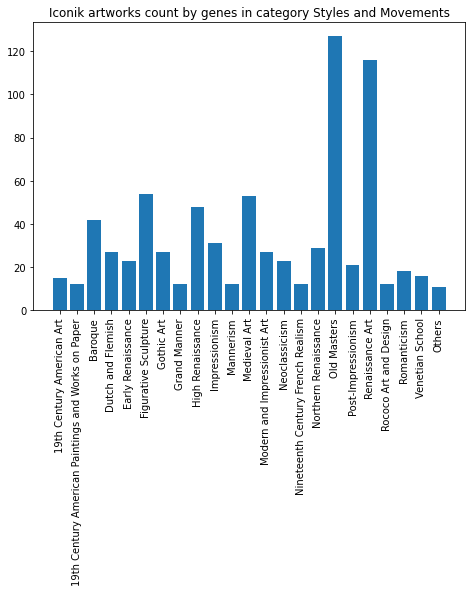

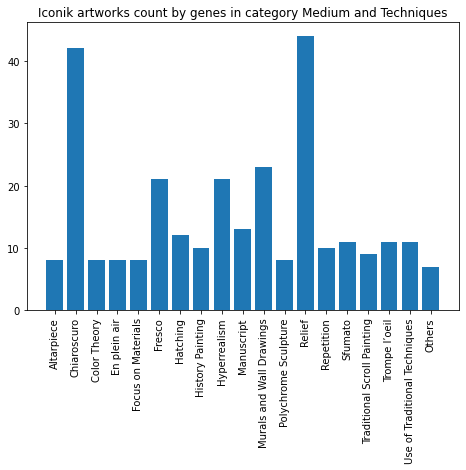

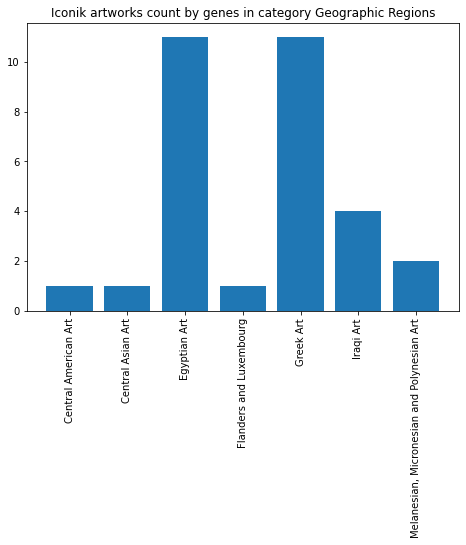

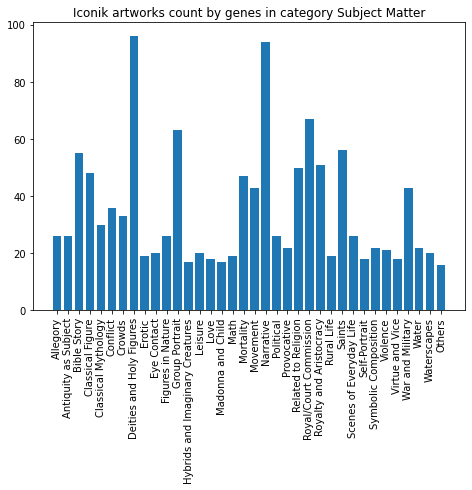

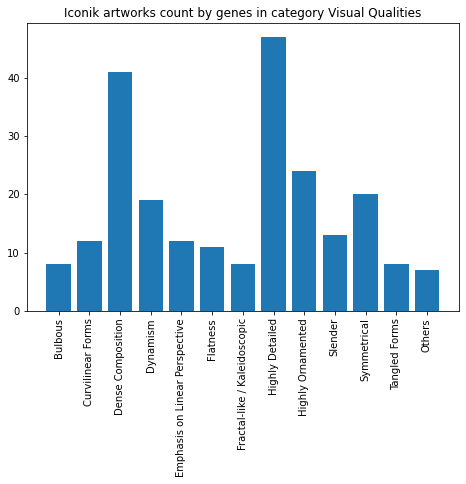

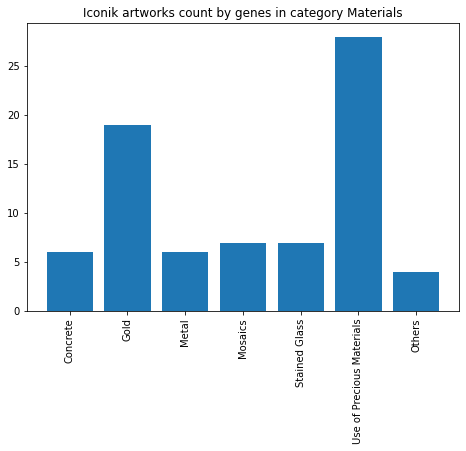

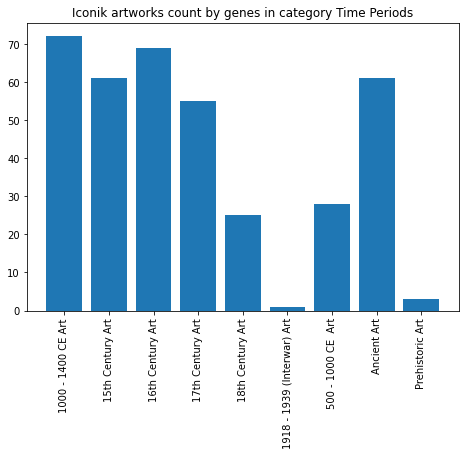

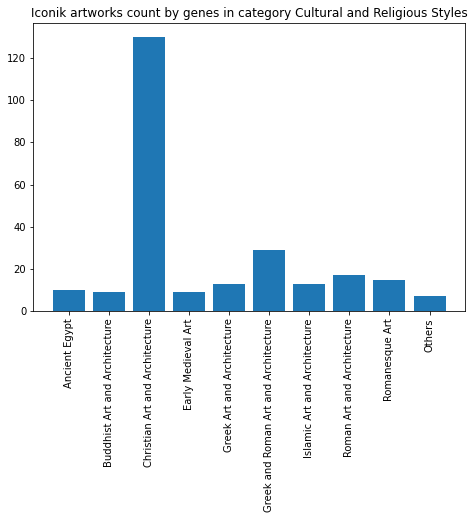

In [39]:
for cat in gene_count_df['category_name'].unique():
  cat_df = gene_count_df.loc[gene_count_df['category_name']==cat]
  if cat_df['gene_name'].nunique() > 10:
    quartile_3 = np.percentile(cat_df['count'], 75)
    big_counts_df = cat_df.loc[cat_df['count'] >= quartile_3]
    small_counts_df = cat_df.loc[cat_df['count'] < quartile_3]
    small_counts_df['gene_name'] = 'Others'
    cat_df_new = pd.concat([big_counts_df, small_counts_df])
  else:
    cat_df_new = cat_df.copy()
  
  fig = plt.figure()
  axes = fig.add_axes([0, 0, 1, 1])
  axes.bar(x = cat_df_new['gene_name'], height = cat_df_new['count'])
  axes.set_xticklabels(cat_df_new['gene_name'], rotation = 90)
  axes.set_title('Iconik artworks count by genes in category {}'.format(cat))
  
  plt.show()

  print('')

In [ ]:
# artists_dict = {'id': {'artsy_id': [], 'category_id': [], 'gene_id': [], 'name': ''}}

#artists_dict = open_dict(artist_dict, 'live') # 2. Open json dict
#len(artists_dict)

# artworks_dict = {'artsy_id': {'artist': '', 'artist_id': '', 'category_id': [], 'gallery': '', 'gene_id': [],
#                               'link': '', 'name': '', 'parsing_date': '', 'price': '', 'updating_date': ', 'year': ''}}

#artworks_dict = open_dict(artwork_dict, 'live') # 2. Open json dict
#len(artworks_dict)

# Images

In [ ]:
# Sample from API tables

# 'image': {'href': 'https://d32dm0rphc51dk.cloudfront.net/NOpIAwQa-3r51Cg9qXKbfA/{image_version}.jpg',
#                      'templated': True}
#i = 'https://d32dm0rphc51dk.cloudfront.net/NOpIAwQa-3r51Cg9qXKbfA/normalized.jpg'
#for p in i.split('.jpg')[0].split('/'):
#  print(len(p), p)

6 https:
0 
29 d32dm0rphc51dk.cloudfront.net
22 NOpIAwQa-3r51Cg9qXKbfA
10 normalized


In [ ]:
#! pip install pillow --user

import PIL
from PIL import Image
import os
import cv2

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [ ]:
image = requests.get(img, headers={'User-Agent': 'Chrome/97.0.4692.71'})
name = art_project_path + '/' + 'portrait_of_a_man_in_armour' + '.jpg'

img = open(name, 'wb')
img.write(image.content)
img.close()

img = Image.open(name)
plt.imshow(img)
plt.axis('off')
plt.show()

img.close()